In [1]:
import os
import pandas as pd
import argparse
import pickle
import os
import sys
import torch
import rdkit
import numpy as np
#import warnings
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import fmin, hp, tpe
from argparse import ArgumentParser, Namespace
from copy import deepcopy
import json
from typing import Dict, Union
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import PandasTools

In [2]:
datasets = ["Homopiperazines","Piperazines","Piperidines","Sulphamides"]
names = ["JAK1 EC50 nM 1027","JAK2 EC50 nM 1024","JAK3 EC50 nM 1026"]
names = names + ['TYK2 EC50 nM 1025']
files = ["/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperidines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Sulphamides_cleaned_Feb_2019.sdf",
        ]
PARENT_DIR = '/dbfs/FileStore/tables'
PICKLES_DIR = '/dbfs/FileStore/pickles'
MOSES_DIR = '/dbfs/FileStore/moses'
CHEMPROP_DIR = '/dbfs/FileStore/chemprop'
GITCLONES_DIR = '/dbfs/FileStore/git-clones'
ZINC_DIR = '/dbfs/FileStore/ZINC'
ZINC_Models = os.path.join(ZINC_DIR,'models')
VIRTUAL_SCREENING = os.path.join(ZINC_DIR,'virtual_screening')
targets=['JAK1','JAK2','JAK3','TYK2']


In [3]:
%run /Users/vxjdk@leo-pharma.com/mol_utils

In [4]:
%sh
cd /dbfs/FileStore/tables
rm data.tar.gz*
wget https://github.com/swansonk14/chemprop/raw/master/data.tar.gz
tar xvzf data.tar.gz

# Preprocessing

In [6]:
X_train = pd.read_csv(os.path.join(PARENT_DIR,'X_train_smiles.txt'), 
                      header=None).rename(columns={0:'smiles'})
X_test = pd.read_csv(os.path.join(PARENT_DIR,'X_test_smiles.txt'), 
                     header=None).rename(columns={0:'smiles'})
for name in names:
  #full_internal[name]=pd.read_csv(os.path.join(PARENT_DIR,name+'-full.txt'), header=None,index=False)
  X_train[name]=-np.log10(np.array(pd.read_csv(os.path.join(PARENT_DIR,name+'-y_train.txt'), 
                            header=None, squeeze=True)).astype(float)*1e-9)
  X_test[name]=-np.log10(np.array(pd.read_csv(os.path.join(PARENT_DIR,name+'-y_test.txt'), 
                           header=None, squeeze=True)).astype(float)*1e-9)
print(X_train.shape)
print(X_test.shape)


(1460, 5)
(365, 5)

In [7]:
from sklearn.model_selection import train_test_split
val, test = train_test_split(X_test, test_size=0.5)

In [8]:
os.mkdir(CHEMPROP_DIR)
os.mkdir(os.path.join(CHEMPROP_DIR,'JAK'))
os.mkdir(os.path.join(CHEMPROP_DIR,'JAK','checkpoints'))

In [9]:
X_all = X_train.append(X_test)
X_all.columns = ['smiles']+targets
X_all.to_csv(os.path.join(CHEMPROP_DIR,'JAK','all_1825-regression.csv'),index=None)

In [10]:
val.to_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182.csv'),index=None)
test.to_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'),index=None)
X_train.to_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460.csv'),index=None)

In [11]:
frame = pd.read_csv('/dbfs/FileStore/tables/frame.csv')
#frame.columns = targets + ['SMILES']
#frame = frame[['SMILES']+targets]
print(len(frame))
for name in names:
  frame[name]=-np.log10(np.array(frame[name]).astype(float)*1e-9)
frame.columns = targets+['smiles']
frame = frame[['smiles']+targets]
print(frame.columns)
frame.to_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'),index=False)

2188
Index(['smiles', 'JAK1', 'JAK2', 'JAK3', 'TYK2'], dtype='object')

In [12]:
for name in targets:
  frame[name] = frame[name].apply(lambda x: 1 if x > 7.6 else 0)
frame.to_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-bin_76.csv'),index=False)
display(frame.head())

smiles,JAK1,JAK2,JAK3,TYK2
CN(C[C@H]1C[C@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2,0,0,0,0
CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2,0,1,0,0
CN(C[C@H]1CCCN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2,0,1,0,0
N#CCC(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2,0,0,0,0
CNS(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)C2CC21,0,0,0,0


### Binarization

In [14]:
%sh head '/dbfs/FileStore/tables/TYK2 EC50 nM 1025-smiles.txt'

SMILES
CN(C[C@H]1C[C@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@H]1CCCN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCC(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
CN(CC1CC(F)(F)C1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)C2CC21
N#Cc1ccc(CC(=O)N2CCN(c3ncnc4[nH]ccc34)C3CC32)cc1
c1nc(N2CCNC3CC32)c2cc[nH]c2n1
CN(C[C@@H]1CC(F)(F)CN1)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
CS(=O)(=O)N1CC(F)(F)C[C@H]1COC(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2

In [15]:
for name in names:
  df = frame.dropna(subset=[name])
  df[name]=-np.log10(np.array(df[name]).astype(float)*1e-9)
  df[name] = df[name].apply(lambda x: 1 if x > 7.6 else 0)
  df.filter(['SMILES',name]).rename(columns = {'SMILES':'smiles'}).to_csv('/dbfs/FileStore/tables/'+name+'-trues_bin76.csv',index=False)
  df.filter(['SMILES']).rename(columns = {'SMILES':'smiles'}).to_csv('/dbfs/FileStore/tables/'+name+'-smiles.txt',index=False)
display(df.head())

JAK1 EC50 nM 1027,JAK2 EC50 nM 1024,JAK3 EC50 nM 1026,TYK2 EC50 nM 1025,SMILES
47.2,49.3,73.5,0,CN(C[C@H]1C[C@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
26.4,16.6,99.8,0,CN(C[C@H]1C[C@@H](F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
31.2,24.1,148.0,0,CN(C[C@H]1CCCN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
330.0,512.0,1350.0,0,N#CCC(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
116.0,259.0,710.0,0,CN(CC1CC(F)(F)C1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)C2CC21


In [16]:
val = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182.csv'))
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'))
train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460.csv'))

In [17]:
dfs = [val,test,train]
for df in dfs:
  for name in names:
    df[name] = df[name].apply(lambda x: 1 if x > 8 else 0)
display(dfs[0].head())

smiles,JAK1 EC50 nM 1027,JAK2 EC50 nM 1024,JAK3 EC50 nM 1026,TYK2 EC50 nM 1025
CN(CC1CCN(C(=O)CCO)CC1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2,0,0,0,0
O=C(c1cnc2ccccc2n1)N1CCN(c2ncnc3[nH]cc(Cl)c23)CC12CC2,0,0,0,0
Cc1cnc(C(=O)N2[C@H]3CC[C@@H]2CN(c2ncnc4[nH]ccc24)C3)cn1,0,0,0,0
N#CCC(=O)N1CC[C@@H](NC(=O)[C@H]2CCN(c3ncnc4[nH]ccc34)CC23CC3)C1,0,0,0,0
C[C@H](NC(=O)C1CCN(c2ncnc3[nH]ccc23)CC12CC2)c1ccc(C#N)cc1,1,1,1,0


In [18]:
dfs[0].to_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182_binary.csv'),index=None)
dfs[1].to_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_binary.csv'),index=None)
dfs[2].to_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460_binary.csv'),index=None)

Adding PubChem dataset

In [20]:
bin_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460_binary.csv'))
display(bin_train.head())

smiles,JAK1 EC50 nM 1027,JAK2 EC50 nM 1024,JAK3 EC50 nM 1026,TYK2 EC50 nM 1025
Cc1c[nH]c(C(=O)N2CCCN(c3ncnc4[nH]ccc34)CC23CC3)c1,0,0,0,0
O=S(=O)(N(CCN1CCOCC1)C1CCC1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2,0,0,0,0
CN(C[C@@H]1CCCN1S(C)(=O)=O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2,0,0,0,0
CC(=O)N1CC[C@H]1COC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2,0,0,0,0
N#Cc1ccc(CC(=O)N2CCN(c3ncnc4[nH]ccc34)C3(CC3)C2)cc1,0,0,0,0


In [21]:
csvs = ['JAK1_20190311.csv', 
        'JAK2_20190311.csv', 
        'JAK3_20190311.csv', 
        'TYK2_20190311.csv']
sdfs = ['JAK1_20190311_sdf-d4409.gz', 
        'JAK2_20190311_sdf-3d49e.gz', 
        'JAK3_20190311_sdf-08df5.gz', 
        'TYK2_20190311_sdf-6ca3e.gz']

ext_dfs = []
for j, file in enumerate(csvs):
  frame = external_prep('/'.join([PARENT_DIR, file]), 
                        '/'.join([PARENT_DIR, sdfs[j]]))
  frame.drop_duplicates(subset='cid', inplace=True)
  frame.dropna(subset=['acvalue'],inplace=True)
  frame[sdfs[j][:4]] = -np.log10(np.array([val*1e-6 for val in frame['acvalue']]).astype(float))
  ext_dfs.append(frame)

In [22]:
all_internal = train.append(val)
all_internal = all_internal.append(test)
all_internal['Molecule'] = [Chem.MolFromSmiles(smi) for smi in all_internal['smiles']]
for df in ext_dfs:
  print(any(df['Molecule'].isin(all_internal['Molecule'])))

False
False
False
False

In [23]:
#ext_all = ext_dfs[0]
from functools import reduce
for j, df in enumerate(ext_dfs):
  #df['smiles'] = [Chem.MolToSmiles(mol) for mol in df['Molecule']]
  ext_dfs[j] = df.filter(['smiles',sdfs[j][:4]]).dropna()
df_all = reduce(lambda left,right: pd.merge(left,right,on='smiles', how='outer'), ext_dfs)

In [24]:
for col in sdfs:
  df_all[col[:4]] = df_all[col[:4]].apply(lambda x: int(0) if x < 7.1 else x)
  df_all[col[:4]] = df_all[col[:4]].apply(lambda x: int(1) if x >= 8.1 else x)
  df_all[col[:4]] = df_all[col[:4]].apply(lambda x: None if (x < 8.1 and x >= 7.1) else x)

In [25]:
display(df_all.head())

smiles,JAK1,JAK2,JAK3,TYK2
COCCOC1CCCN(S(=O)(=O)CC2CCC(N(C)c3ncnc4[nH]ccc34)CC2)C1,1.0,1.0,1.0,NaN
CC(C)COC1CCCN(S(=O)(=O)CC2CCC(N(C)c3ncnc4[nH]ccc34)CC2)C1,1.0,1.0,1.0,NaN
C[C@H]1CN(S(=O)(=O)CC2CCC(N(C)c3ncnc4[nH]ccc34)CC2)C[C@@H]1CO,1.0,1.0,1.0,NaN
CN(c1ncnc2[nH]ccc12)C1CCC(CS(=O)(=O)N2CCC(C)(O)C2)CC1,1.0,1.0,1.0,NaN
N#CCC1(n2cc(C(N)=O)c(Nc3ccc(-c4cn[nH]c4)nc3)n2)CCN(C(=O)OCC(F)(F)F)CC1,1.0,1.0,NaN,NaN


In [26]:
for df in dfs:
  df.columns = ['smiles','JAK1','JAK2','JAK3','TYK2']

dfs[2] = dfs[2].append(df_all)
dfs[2].shape

Out[83]: (8396, 5)

In [27]:
dfs[0].to_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),index=None,float_format='%.0f')
dfs[1].to_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),index=None,float_format='%.0f')
dfs[2].to_csv(os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'),index=None,float_format='%.0f')
train.to_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'),index=None,float_format='%.0f')

# Hyperparameter tuning

In [29]:
from chemprop.models import build_model
from chemprop.nn_utils import param_count
from chemprop.parsing import add_train_args, modify_train_args
from chemprop.train import cross_validate
from chemprop.utils import create_logger, makedirs
from chemprop.features import get_available_features_generators

In [30]:
SPACE = {
    'hidden_size': hp.quniform('hidden_size', low=300, high=2400, q=100),
    'depth': hp.quniform('depth', low=2, high=6, q=1),
    'dropout': hp.quniform('dropout', low=0.0, high=0.4, q=0.05),
    'ffn_num_layers': hp.quniform('ffn_num_layers', low=1, high=3, q=1)
}
INT_KEYS = ['hidden_size', 'depth', 'ffn_num_layers']

In [31]:
def grid_search(args: Namespace):
    # Create loggers
    logger = create_logger(name='hyperparameter_optimization', save_dir=args.log_dir, quiet=True)
    train_logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

    # Run grid search
    results = []

    # Define hyperparameter optimization
    def objective(hyperparams: Dict[str, Union[int, float]]) -> float:
        # Convert hyperparams from float to int when necessary
        for key in INT_KEYS:
            hyperparams[key] = int(hyperparams[key])

        # Update args with hyperparams
        hyper_args = deepcopy(args)
        if args.save_dir is not None:
            folder_name = '_'.join(f'{key}_{value}' for key, value in hyperparams.items())
            hyper_args.save_dir = os.path.join(hyper_args.save_dir, folder_name)
        for key, value in hyperparams.items():
            setattr(hyper_args, key, value)

        # Record hyperparameters
        logger.info(hyperparams)

        # Cross validate
        mean_score, std_score = cross_validate(hyper_args, train_logger)

        # Record results
        temp_model = build_model(hyper_args)
        num_params = param_count(temp_model)
        logger.info(f'num params: {num_params:,}')
        logger.info(f'{mean_score} +/- {std_score} {hyper_args.metric}')

        results.append({
            'mean_score': mean_score,
            'std_score': std_score,
            'hyperparams': hyperparams,
            'num_params': num_params
        })

        # Deal with nan
        if np.isnan(mean_score):
            if hyper_args.dataset_type == 'classification':
                mean_score = 0
            else:
                raise ValueError('Can\'t handle nan score for non-classification dataset.')

        return (1 if hyper_args.minimize_score else -1) * mean_score

    fmin(objective, SPACE, algo=tpe.suggest, max_evals=args.num_iters)

    # Report best result
    results = [result for result in results if not np.isnan(result['mean_score'])]
    best_result = min(results, key=lambda result: (1 if args.minimize_score else -1) * result['mean_score'])
    logger.info('best')
    logger.info(best_result['hyperparams'])
    logger.info(f'num params: {best_result["num_params"]:,}')
    logger.info(f'{best_result["mean_score"]} +/- {best_result["std_score"]} {args.metric}')

    # Save best hyperparameter settings as JSON config file
    makedirs(args.config_save_path, isfile=True)

    with open(args.config_save_path, 'w') as f:
        json.dump(best_result['hyperparams'], f, indent=4, sort_keys=True)


In [32]:
parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=40,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460.csv'),
                         '--dataset_type','regression',
                         '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints'),
                         '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182.csv'),
                         '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'),
                         '--config_save_path',os.path.join(CHEMPROP_DIR,'JAK','configs','regression-4x.json'),
                         '--log_dir',os.path.join(CHEMPROP_DIR,'JAK','configs')])
modify_train_args(args)

grid_search(args)

0%| | 0/20 [00:00<?, ?it/s, best loss: ?]{'depth': 4, 'dropout': 0.15000000000000002, 'ffn_num_layers': 3, 'hidden_size': 900}
{'depth': 4, 'dropout': 0.15000000000000002, 'ffn_num_layers': 3, 'hidden_size': 900}
Fold 0
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/regression-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460.csv',
 'dataset_type': 'regression',
 'depth': 4,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 900,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 20,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/depth_4_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_900/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/regression-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460.csv',
 'dataset_type': 'regression',
 'depth': 4,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 900,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 20,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/depth_4_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_900/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/regression-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460.csv',
 'dataset_type': 'regression',
 'depth': 4,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size':

### Classification hyperparameter tuning

In [34]:
parser = ArgumentParser()
add_train_args(parser)
os.mkdir(os.path.join(CHEMPROP_DIR,'JAK','checkpoints','binary-4x'))
os.mkdir(os.path.join(CHEMPROP_DIR,'JAK','configs','binary-4x'))
parser.add_argument('--num_iters', type=int, default=40,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460_binary.csv'),
                         '--dataset_type','classification',
                         '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','binary-4x'),
                         '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_binary.csv'),
                         '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_binary.csv'),
                         '--config_save_path',os.path.join(CHEMPROP_DIR,'JAK','configs','binary-4x.json'),
                         '--log_dir',os.path.join(CHEMPROP_DIR,'JAK','configs','binary-4x')])
modify_train_args(args)

grid_search(args)

0%| | 0/20 [00:00<?, ?it/s, best loss: ?]{'depth': 2, 'dropout': 0.2, 'ffn_num_layers': 1, 'hidden_size': 1800}
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/binary-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_binary.csv',
 'dataset_type': 'classification',
 'depth': 2,
 'dropout': 0.2,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1800,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs/binary-4x',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 20,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/binary-4x/depth_2_dropout_0.2_ffn_num_layers_1_hidden_size_1800/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_binary.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_binary.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
  0%| | 0/1460 [00:00<?, ?it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?]  21%|## | 305/1460 [00:00<00:00, 3042.82it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?]  43%|####3 | 628/1460 [00:00<00:00, 3096.42it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?]  65%|######4 | 947/1460 [00:00<00:00, 3123.83it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?]  87%|########7 | 1271/1460 [00:00<00:00, 3157.59it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 100%|##########| 1460/1460 [00:00<00:00, 3185.60it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?]Number of tasks = 4
Splitting data with seed 0
  0%| | 0/183 [00:00<?, ?it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 100%|##########| 183/183 [00:00<00:00, 3273.07it/s]
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:00<?, ?it/s, best loss: ?]  0%| | 0/182 [00:00<?, ?it/s]
 0%| | 0/20 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:01<?, ?it/s, best loss: ?] 100%|##########| 182/182 [00:00<00:00, 3237.81it/s]
 0%| | 0/20 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/20 [00:01<?, ?it/s, best loss: ?]Class sizes
JAK1 EC50 nM 1027 0: 68.56%, 1: 31.44%
JAK2 EC50 nM 1024 0: 72.40%, 1: 27.60%
JAK3 EC50 nM 1026 0: 93.15%, 1: 6.85%
TYK2 EC50 nM 1025 0: 98.08%, 1: 1.92%
Total size = 1,460 | train size = 1,460 | val size = 182 | test size = 183
Building model 0
MoleculeModel(
 (sigmoid): Sigmoid()
 (encoder): MPN(
 (encoder): MPNEncoder(
 (dropout_layer): Dropout(p=0.2)
 (act_func): ReLU()
 (W_i): Linear(in_features=147, out_features=1800, bias=False)
 (W_h): Linear(in_features=1800, out_features=1800, bias=False)
 (W_o): Linear(in_features=1933, out_features=1800, bias=True)
 )
 )
 (ffn): Sequential(
 (0): Dropout(p=0.2)
 (1): Linear(in_features=1800, out_features=4, bias=True)
 )
)
Number of parameters = 6,993,004
Moving model to cuda
  0%| | 0/30 [00:00<?, ?it/s]
 0%| | 0/20 [00:08<?, ?it/s, best loss: ?] 
 0

#### With PubChem dataset

In [36]:
parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=40,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'),
                         '--dataset_type','classification',
                         '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','bin76_ext'),
                         '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                         '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                         '--config_save_path',os.path.join(CHEMPROP_DIR,'JAK','configs','bin76_ext.json'),
                         '--log_dir',os.path.join(CHEMPROP_DIR,'JAK','configs','bin76_ext'),
                         #'--num_folds','3',
                         '--seed','13'])
modify_train_args(args)

grid_search(args)
#dfs[2].to_csv(os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'),index=None)
#train.to_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'),index=None)

0%| | 0/40 [00:00<?, ?it/s, best loss: ?]{'depth': 2, 'dropout': 0.15000000000000002, 'ffn_num_layers': 3, 'hidden_size': 1100}
{'depth': 2, 'dropout': 0.15000000000000002, 'ffn_num_layers': 3, 'hidden_size': 1100}
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 2,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1100,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 40,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/bin76_ext/depth_2_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_1100/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 2,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1100,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 40,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/bin76_ext/depth_2_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_1100/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
Loading data
  0%| | 0/8396 [00:00<?, ?it/s]
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?]  4%|4 | 336/8396 [00:00<00:02, 3358.31it/s]
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?]  8%|7 | 664/8396 [00:00<00:02, 3331.61it/s]
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?]  12%|#1 | 995/8396 [00:00<00:02, 3323.76it/s]
 0%| | 0/40 [00:00<?,

In [37]:
#Ext feat_slogp
parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=40,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtrain-8396.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','bin76_ext_Feat_SLogP'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--config_save_path',os.path.join(CHEMPROP_DIR,'JAK','configs','bin76_ext_Feat_SLogP.json'),
                          '--log_dir',os.path.join(CHEMPROP_DIR,'JAK','configs','bin76_ext_Feat_SLogP')])
modify_train_args(args)

grid_search(args)

0%| | 0/40 [00:00<?, ?it/s, best loss: ?]{'depth': 6, 'dropout': 0.15000000000000002, 'ffn_num_layers': 3, 'hidden_size': 300}
{'depth': 6, 'dropout': 0.15000000000000002, 'ffn_num_layers': 3, 'hidden_size': 300}
Fold 0
Fold 0
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext_Feat_SLogP.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 6,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 300,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext_Feat_SLogP',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 40,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/bin76_ext_Feat_SLogP/depth_6_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_300/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext_Feat_SLogP.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 6,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 300,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs/bin76_ext_Feat_SLogP',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 40,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/bin76_ext_Feat_SLogP/depth_6_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_300/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'bat

In [38]:
#Int feat_slogp
parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=40,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')

args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtrain-1460.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','bin76_int_Feat_SLogP'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--config_save_path',os.path.join(CHEMPROP_DIR,'JAK','configs','bin76_int_Feat_SLogP.json'),
                          '--log_dir',os.path.join(CHEMPROP_DIR,'JAK','configs','bin76_int_Feat_SLogP')])
modify_train_args(args)

grid_search(args)

0%| | 0/40 [00:00<?, ?it/s, best loss: ?]{'depth': 3, 'dropout': 0.0, 'ffn_num_layers': 3, 'hidden_size': 2100}
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/configs/bin76_int_Feat_SLogP.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_bin76.csv',
 'dataset_type': 'classification',
 'depth': 3,
 'dropout': 0.0,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2100,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/configs/bin76_int_Feat_SLogP',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 40,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/bin76_int_Feat_SLogP/depth_3_dropout_0.0_ffn_num_layers_3_hidden_size_2100/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
  0%| | 0/1460 [00:00<?, ?it/s]
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?]  17%|#7 | 251/1460 [00:00<00:00, 2503.60it/s]
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?]  39%|###8 | 564/1460 [00:00<00:00, 2663.12it/s]
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?]  60%|#####9 | 873/1460 [00:00<00:00, 2777.67it/s]
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:00<?, ?it/s, best loss: ?]  81%|######## | 1176/1460 [00:00<00:00, 2848.03it/s]
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 100%|##########| 1460/1460 [00:00<00:00, 2962.82it/s]
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?]Number of tasks = 4
Splitting data with seed 0
  0%| | 0/183 [00:00<?, ?it/s]
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 100%|##########| 183/183 [00:00<00:00, 3097.38it/s]
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?]  0%| | 0/182 [00:00<?, ?it/s]
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 100%|##########| 182/182 [00:00<00:00, 3026.24it/s]
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?] 
 0%| | 0/40 [00:01<?, ?it/s, best loss: ?]Class sizes
JAK1 0: 50.89%, 1: 49.11%
JAK2 0: 55.27%, 1: 44.73%
JAK3 0: 83.56%, 1: 16.44%
TYK2 0: 93.56%, 1: 6.44%
Total size = 1,460 | train size = 1,460 | val size = 182 | test size = 183
Building model 0
MoleculeModel(
 (sigmoid): Sigmoid()
 (encoder): MPN(
 (encoder): MPNEncoder(
 (dropout_layer): Dropout(p=0.0)
 (act_func): ReLU()
 (W_i): Linear(in_features=147, out_features=2100, bias=False)
 (W_h): Linear(in_features=2100, out_features=2100, bias=False)
 (W_o): Linear(in_features=2233, out_features=2100, bias=True)
 )
 )
 (ffn): Sequential(
 (0): Dropout(p=0.0)
 (1): Linear(in_features=2101, out_fe

# Training

In [40]:
from argparse import ArgumentParser, Namespace
from chemprop.parsing import parse_train_args
from chemprop.parsing import add_train_args
from chemprop.parsing import modify_train_args

from chemprop.train import cross_validate
from chemprop.utils import create_logger

In [41]:
parser = ArgumentParser()
add_train_args(parser)
args = parser.parse_args(['-h'])
args = modify_train_args(args)

cross_validate(args)

An exception has occurred, use %tb to see the full traceback.

 SystemExit : 0

In [42]:
%sh cp /dbfs/FileStore/chemprop/JAK/train-1460.csv /dbfs/FileStore/chemprop/JAK/all-1825.csv 
sed 1d /dbfs/FileStore/chemprop/JAK/test-183.csv >> /dbfs/FileStore/chemprop/JAK/all-1825.csv 
sed 1d /dbfs/FileStore/chemprop/JAK/val-182.csv >> /dbfs/FileStore/chemprop/JAK/all-1825.csv 
wc /dbfs/FileStore/chemprop/JAK/all-1825.csv 

1826 1838 235037 /dbfs/FileStore/chemprop/JAK/all-1825.csv

In [43]:
%sh cat /dbfs/FileStore/chemprop/JAK/configs/regression-4x.json

{
 "depth": 4,
 "dropout": 0.1,
 "ffn_num_layers": 2,
 "hidden_size": 2000
}

#### Classification external vs internal pEC 7.6

In [45]:
%sh cat /dbfs/FileStore/chemprop/JAK/configs/bin76_ext.json

{
 "depth": 5,
 "dropout": 0.05,
 "ffn_num_layers": 2,
 "hidden_size": 1500
}

In [46]:
%sh cat /dbfs/FileStore/chemprop/JAK/configs/bin76_int.json

{
 "depth": 5,
 "dropout": 0.15000000000000002,
 "ffn_num_layers": 1,
 "hidden_size": 1300
}

In [47]:
#External
parser = ArgumentParser()
add_train_args(parser)
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--log_frequency','1',
                          '--depth','5',
                          '--dropout','0.05',
                          '--hidden_size','1500',
                          '--ffn_num_layers','2',
                          '--epochs','50'
                        #,'--atom_messages'
                        #,'--ensemble_size','3'
                        #,'--features_generator','rdkit_2d'
                         ,'--seed','13',
                          ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)
#test auc = 0.889156 - 50epoch
#test auc = 0.879814 - 30epoch
#test auc = 0.873914 - 11epoch
#best validation auc = 0.915431 on epoch 26
#best validation auc = 0.938879 on epoch 11
#best validation auc = 0.920827 on epoch 9

Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 5,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 1500,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1500,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
 0%| | 0/8396 [00:00<?, ?it/s] 4%|▍ | 315/8396 [00:00<00:02, 3145.29it/s] 8%|▊ | 649/8396 [00:00<00:02, 3201.09it/s] 12%|█▏ | 980/8396 [00:00<00:02, 3231.99it/s] 16%|█▌ | 1307/8396 [00:00<00:02, 3242.27it/s] 20%|█▉ | 1638/8396 [00:00<00:02, 3260.32it/s] 23%|██▎ | 1917/8396 [00:00<00:02, 3103.35it/s] 26%|██▌ | 2193/8396 [00:00<00:02, 2953.81it/s] 30%|██▉ | 2483/8396 [00:00<00:02, 2934.35it/s] 33%|███▎ | 2803/8396 [00:00<00:01, 3007.49it/s] 37%|███▋ | 3136/8396 [00:01<00:01, 3095.88it/s] 41%|████ | 3439/8396 [00:01<00:01, 2890.28it/s] 44%|████▍ | 3726/8396 [00:01<00:01, 2864.23it/s] 48%|████▊ | 4058/8396 [00:01<00:01, 2985.24it/s] 52%|█████▏ | 4380/8396 [00:01<00:01, 3051.72it/s] 56%|█████▋ | 4727/8396 [00:01<00:01, 3163.64it/s] 60%|██████ | 5079/8396 [00:01<00:01, 3260.08it/s] 65%|██████▍ | 5434/8396 [00:01<00:00, 3341.02it/s] 69%|██████▊ | 5770/8396 [00:01<00:00, 3338.82it/s] 73%|███████▎ | 6106/8396 [00:01<00:00, 3284.21it/s] 77%|███████▋ | 6436/8396 [00:02<00:00, 3209.43it/s] 81%|████████ | 6759/8396 [00:02<00:00, 3214.21it/s] 85%|████████▍ | 7095/8396 [00:02<00:00, 3255.23it/s] 89%|████████▉ | 7452/8396 [00:02<00:00, 3341.27it/s] 93%|█████████▎| 7827/8396 [00:02<00:00, 3452.53it/s] 97%|█████████▋| 8174/8396 [00:02<00:00, 3442.89it/s]100%|██████████| 8396/8396 [00:02<00:00, 3204.48it/s]
Number of tasks = 4
Splitting data with seed 13
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 3246.42it/s]
 0%| | 0/182 [00:00<?, ?it/s]100%|██████████| 182/182 [00:00<00:00, 3254.25it/s]
Class sizes
JAK1 0: 33.55%, 1: 66.45%
JAK2 0: 60.19%, 1: 39.81%
JAK3 0: 77.42%, 1: 22.58%
TYK2 0: 92.62%, 1: 7.38%
Total size = 8,396 | train size = 8,396 | val size = 182 | test size = 183
Building model 0
MoleculeModel(
 (sigmoid): Sigmoid()
 (encoder): MPN(
 (encoder): MPNEncoder(
 (dropout_layer): Dropout(p=0.05)
 (act_func): ReLU()
 (W_i): Linear(in_features=147, out_features=1500, bias=False)
 (W_h): Linear(in_features=1500, out_features=1500, bias=False)
 (W_o): Linear(in_features=1633, out_features=1500, bias=True)
 )
 )
 (ffn): Sequential(
 (0): Dropout(p=0.05)
 (1): Linear(in_features=1500, out_features=1500, bias=True)
 (2): ReLU()
 (3): Dropout(p=0.05)
 (4): Linear(in_features=1500, out_features=4, bias=True)
 )
)
Number of parameters = 7,179,004
Moving model to cuda
 0%| | 0/50 [00:00<?, ?it/s]Epoch 0

 0%| | 0/167 [00:00<?, ?it/s]Loss = 1.3349e-02, PNorm = 69.5572, GNorm = 2.3014, lr_0 = 1.0269e-04

 1%| | 1/167 [00:00<00:26, 6.20it/s]Loss = 1.2354e-02, PNorm = 69.5578, GNorm = 0.7841, lr_0 = 1.0539e-0

In [48]:
#LEO + PubChem 0.8726888202188564
parser = ArgumentParser()
add_train_args(parser)
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext-50e'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--log_frequency','1',
                          '--depth','5',
                          '--dropout','0.05',
                          '--hidden_size','1500',
                          '--ffn_num_layers','2',
                          '--epochs','50'
                        #,'--atom_messages'
                        #,'--ensemble_size','3'
                        #,'--features_generator','rdkit_2d'
                        # ,'--seed','13',
                          ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)
#test auc = 0.889156 - 50epoch
#test auc = 0.879814 - 30epoch
#test auc = 0.873914 - 11epoch
#best validation auc = 0.915431 on epoch 26
#best validation auc = 0.938879 on epoch 11
#best validation auc = 0.920827 on epoch 9
#100e test auc = 0.868794

Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 5,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 1500,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1500,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext-50e/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
 0%| | 0/8396 [00:00<?, ?it/s] 3%|▎ | 279/8396 [00:00<00:02, 2785.10it/s] 7%|▋ | 580/8396 [00:00<00:02, 2846.85it/s] 10%|█ | 880/8396 [00:00<00:02, 2889.87it/s] 14%|█▍ | 1172/8396 [00:00<00:02, 2897.27it/s] 18%|█▊ | 1474/8396 [00:00<00:02, 2931.27it/s] 21%|██ | 1758/8396 [00:00<00:02, 2900.75it/s] 24%|██▍ | 2016/8396 [00:00<00:02, 2722.05it/s] 27%|██▋ | 2268/8396 [00:00<00:02, 2618.12it/s] 30%|███ | 2526/8396 [00:00<00:02, 2604.70it/s] 34%|███▎ | 2815/8396 [00:01<00:02, 2681.87it/s] 37%|███▋ | 3115/8396 [00:01<00:01, 2767.35it/s] 40%|████ | 3389/8396 [00:01<00:01, 2546.87it/s] 43%|████▎ | 3645/8396 [00:01<00:01, 2436.67it/s] 47%|████▋ | 3946/8396 [00:01<00:01, 2583.29it/s] 51%|█████ | 4258/8396 [00:01<00:01, 2722.57it/s] 54%|█████▍ | 4556/8396 [00:01<00:01, 2794.03it/s] 58%|█████▊ | 4869/8396 [00:01<00:01, 2885.75it/s] 62%|██████▏ | 5175/8396 [00:01<00:01, 2933.49it/s] 65%|██████▌ | 5487/8396 [00:01<00:00, 2985.80it/s] 69%|██████▉ | 5789/8396 [00:02<00:00, 2995.22it/s] 73%|███████▎ | 6090/8396 [00:02<00:00, 2907.27it/s] 76%|███████▌ | 6383/8396 [00:02<00:00, 2822.43it/s] 79%|███████▉ | 6667/8396 [00:02<00:00, 2805.70it/s] 83%|████████▎ | 6958/8396 [00:02<00:00, 2834.15it/s] 87%|████████▋ | 7265/8396 [00:02<00:00, 2898.25it/s] 91%|█████████ | 7605/8396 [00:02<00:00, 3029.63it/s] 95%|█████████▍| 7941/8396 [00:02<00:00, 3121.47it/s] 98%|█████████▊| 8256/8396 [00:02<00:00, 3010.74it/s]100%|██████████| 8396/8396 [00:02<00:00, 2847.14it/s]
Number of tasks = 4
Splitting data with seed 0
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 2991.70it/s]
 0%| | 0/182 [00:00<?, ?it/s]100%|██████████| 182/182 [00:00<00:00, 2940.11it/s]
Class sizes
JAK1 0: 33.55%, 1: 66.45%
JAK2 0: 60.19%, 1: 39.81%
JAK3 0: 77.42%, 1: 22.58%
TYK2 0: 92.62%, 1: 7.38%
Total size = 8,396 | train size = 8,396 | val size = 182 | test size = 183
Building model 0
MoleculeModel(
 (sigmoid): Sigmoid()
 (encoder): MPN(
 (encoder): MPNEncoder(
 (dropout_layer): Dropout(p=0.05)
 (act_func): ReLU()
 (W_i): Linear(in_features=147, out_features=1500, bias=False)
 (W_h): Linear(in_features=1500, out_features=1500, bias=False)
 (W_o): Linear(in_features=1633, out_features=1500, bias=True)
 )
 )
 (ffn): Sequential(
 (0): Dropout(p=0.05)
 (1): Linear(in_features=1500, out_features=1500, bias=True)
 (2): ReLU()
 (3): Dropout(p=0.05)
 (4): Linear(in_features=1500, out_features=4, bias=True)
 )
)
Number of parameters = 7,179,004
Moving model to cuda
 0%| | 0/50 [00:00<?, ?it/s]Epoch 0

 0%| | 0/167 [00:00<?, ?it/s]Loss = 1.5320e-02, PNor

In [49]:
#LEO Pharma 0.8548336983537269
parser = ArgumentParser()
add_train_args(parser)
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--log_frequency','1',
                          '--depth','5',
                          '--dropout','0.05',
                          '--hidden_size','1500',
                          '--ffn_num_layers','2',
                          '--epochs','50'
                        #,'--atom_messages'
                        #,'--ensemble_size','3'
                        #,'--features_generator','rdkit_2d'
                         ,'--seed','13',
                          ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)


Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_bin76.csv',
 'dataset_type': 'classification',
 'depth': 5,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 1500,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1500,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_int/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_bin76.csv',
 'dataset_type': 'classification',
 'depth': 5,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 1500,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1500,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_int/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
Loading data
 0%| | 0/1460 [00:00<?, ?it/s] 20%|█▉ | 288/1460 [00:00<00:00, 2873.47it/s] 43%|████▎ | 625/1460 [00:00<00:00, 3005.34it/s] 66%|██████▌ | 964/1460 [00:00<00:00, 3109.86it/s] 89%|████████▉ | 1305/1460 [00:00<00:00, 3192.94it/s]100%|██████████| 1460/1460 [00:00<00:00, 3266.24it/s]
Number of tasks = 4
Number of tasks = 4
Splitting data with seed 13
Splitting data with seed 13
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 3353.48it/s]
 0%| | 0/182 [00:00<?, ?it/s]100%|██████████| 182/182 [00:00<00:00, 3332.23it/s]
Class sizes
Class sizes
JAK1 0: 50.89%, 1: 49.11%
JAK1 0: 50.89%, 1: 49.11%
JAK2 0: 55.27%, 1: 44.73%
JAK2 0: 55.27%, 1: 44.73%
JAK3 0: 83.56%, 1: 16.44%
JAK3 0: 83.56%, 1: 16.44%
TYK2 0: 93.56%, 1: 6.44%
TYK2 0: 93.56%, 1: 6.44%
Total size = 1,460 | train size = 1,460 | val size = 182 | test size = 183
Total size = 1,460 | train size = 1,460 | val size = 182 | test size = 183
Building model 0
Building model 0
MoleculeModel(
 (sigmoid): Sigmoid()
 (encoder): MPN(
 (encoder): MPNEncoder(
 (dropout_layer): Dropout(p=0.05)
 (act_func): ReLU()
 (W_i): Linear(in_features=147, out_features=1500, bias=False)
 (W_h): Linea

#### Classification external vs internal pEC 7.6 w/ feat SLogP

In [51]:
%sh cat /dbfs/FileStore/chemprop/JAK/configs/bin76_ext_Feat_SLogP.json

{
 "depth": 5,
 "dropout": 0.15000000000000002,
 "ffn_num_layers": 1,
 "hidden_size": 2300
}

In [52]:
#LEO + PubCHem 0.8718238387132906
parser = ArgumentParser()
add_train_args(parser)
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-8396_bin76.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtrain-8396.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext_Feat_SLogP'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--log_frequency','1',
                          '--depth','5',
                          '--dropout','0.15',
                          '--ffn_num_layers','1',
                          '--hidden_size','2300',
                          '--epochs','50'
                         ,'--seed','13'
                          ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)

Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 5,
 'dropout': 0.15,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2300,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2300,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext_Feat_SLogP/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-8396_bin76.csv',
 'dataset_type': 'classification',
 'depth': 5,
 'dropout': 0.15,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2300,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2300,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext_Feat_SLogP/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-8396.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
Loading data
 0%| | 0/8396 [00:00<?, ?it/s] 4%|▍ | 323/8396 [00:00<00:02, 3227.97it/s] 8%|▊ | 649/8396 [00:00<00:02, 3236.07it/s] 12%|█▏ | 966/8396 [00:00<00:02, 3215.55it/s] 15%|█▌ | 1283/8396 [00:00<00:02, 3200.43it/s] 19%|█▉ | 1595/8396 [00:00<00:02, 3175.43it/s] 22%|██▏ | 1876/8396 [00:00<00:02, 3050.28it/s] 26%|██▌ | 2145/8396 [00:00<00:02, 2898.02it/s] 29%|██▉ | 2426/8396 [00:00<00:02, 2869.59it/s] 32%|███▏ | 2714/8396 [00:00<00:01, 2872.07it/s] 36%|███▌ | 3037/8396 [00:01<00:01, 2968.42it/s] 40%|███▉ | 3327/8396 [00:01<00:01, 2880.72it/s] 43%|████▎ | 3611/8396 [00:01<00:01, 2724.28it/s] 47%|████▋ | 3930/8396 [00:01<00:01, 2846.31it/s] 51%|█████ | 4259/8396 [00:01<00:01, 2966.27it/s] 54%|█████▍ | 4558/8396 [00:01<00:02, 1827.09it/s] 58%|█████▊ | 4889/839

In [53]:
%sh cat /dbfs/FileStore/chemprop/JAK/configs/bin76_int_Feat_SLogP.json

{
 "depth": 6,
 "dropout": 0.25,
 "ffn_num_layers": 1,
 "hidden_size": 2200
}

In [54]:
#LEO Pharma 0.8683418723401743
parser = ArgumentParser()
add_train_args(parser)
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtrain-1460.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int_Feat_SLogP'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--log_frequency','1',
                          '--depth','6',
                          '--dropout','0.25',
                          '--ffn_num_layers','1',
                          '--hidden_size','2200',
                          '--epochs','50'
                         ,'--seed','13'
                          ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)

Fold 0
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_bin76.csv',
 'dataset_type': 'classification',
 'depth': 6,
 'dropout': 0.25,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_int_Feat_SLogP/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_bin76.csv',
 'dataset_type': 'classification',
 'depth': 6,
 'dropout': 0.25,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_int_Feat_SLogP/fold_0',
 'save_smiles_splits': False,
 'seed': 13,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_bin76.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_bin76.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_bin76.csv',
 'dataset_type': 'classification',
 'depth': 6,
 'dropout': 0.25,
 'ensemble_size': 1,
 'epochs': 50,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,


# Predicting

In [56]:
from chemprop.parsing import parse_predict_args
from chemprop.train import make_predictions
from chemprop.parsing import add_predict_args
from chemprop.parsing import modify_predict_args

In [57]:
parser = ArgumentParser()
add_predict_args(parser)
args = parser.parse_args(['-h'])
args = modify_predict_args(args)
make_predictions(args)

An exception has occurred, use %tb to see the full traceback.

 SystemExit : 0

In [58]:
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'),
                          '--checkpoint_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x','fold_0/model_0/test_preds.csv')])
modify_predict_args(args)
make_predictions(args)

Loading training args
Loading data
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 2918.70it/s]
Validating SMILES
Test size = 183
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/4 [00:00<?, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 41.35it/s]100%|██████████| 1/1 [00:02<00:00, 2.65s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x/fold_0/model_0/test_preds.csv
Out[18]: 
[[6.899637586169948, 6.531157096847112, 6.175900392628288, 5.320111577712392],
 [7.593240553468566, 7.312949170868578, 6.859105123723975, 6.276921745976],
 [8.020992975285782, 7.857408510215259, 7.442176224274623, 6.682392337185232],
 [8.658362812268239, 8.546459274857964, 7.767360477703561, 7.266105693319486],
 [6.864499169382916, 6.645517846372046, 6.011358890164527, 5.472122091479891],
 [7.1040683856700415,
 7.469376671921825,
 6.9059594085544544,
 5.9740965175293335],
 [7.30754328585698, 7.357443363033125, 6.917917163479255, 6.000812272560142],
 [8.009960102787538, 7.956842218289083, 6.984640418591329, 6.709087645729637],
 [8.584225309550554, 8.341514940194493, 7.869507884637914, 7.455692008005942],
 [8.12609317495107, 7.897917402231123, 7.014885601852481, 6.7066224487450254],
 [6.476417210574423, 6.204789671863807, 5.801053758475284, 5.0406507671277],
 [8.338812591161643, 8.224016302414533, 7.397551459203281, 6.903509639881448],
 [7.650031316874766, 7.778541806582597, 7.297534495063218, 6.397647590669345],
 [7.672467871347743, 7.323727732781512, 7.089780923105578, 6.2001155022589565],
 [6.766955175070212, 6.557115935170149, 6.039251893368728, 5.35170020317129],
 [4.950023638578006, 5.086581352722986, 4.931853690920167, 4.382439185456414],
 [7.6207134435795005, 7.548837129888205, 6.953088713780863, 6.180198121195923],
 [8.360827679290793, 8.194650829344278, 7.264586568687507, 6.927689119334243],
 [7.678875753744483, 7.461450493219322, 6.838029098031936, 6.201838884057814],
 [7.103889214926498, 7.383565278559359, 6.446064534127553, 5.925109156652351],
 [8.308746200764306, 8.2779788134243, 7.947611176561811, 7.075904275420901],
 [6.822823360091342, 6.776854240480904, 6.244417084216265, 5.340652379941437],
 [7.411881564576869, 7.237566742783765, 6.452107530308637, 6.0505619912191575],
 [8.561261024029912, 8.237095981919294, 7.661343148792008, 7.3807019277152115],
 [7.443728556691487, 7.460667850117051, 6.734979631675984, 6.211487137462194],
 [8.4924418282286, 8.246636898065288, 7.772974585724306, 7.338037343749908],
 [5.863901299133064, 5.953659515003183, 5.446369942442336, 4.694003884348164],
 [7.230360454086937, 7.098380570681725, 6.319552259242483, 5.808197799064974],
 [7.16277900057464, 7.021496489010715, 6.441216418645131, 5.763310015665831],
 [6.937983989459417, 6.681725187243604, 6.227975774874055, 5.456763818583041],
 [7.768479601084319, 7.39774500738674, 7.01236478380439, 6.2825145648130345],
 [8.144314250887188, 7.996885113087711, 7.086142397261297, 6.744770979099277],
 [7.4815368807662415, 7.445972418233734, 6.637195239400001, 6.113930799800478],
 [7.3619230480395235, 7.214039203928581, 6.712841966826436, 5.952983384543003],
 [7.689779387834453, 7.314106605589771, 6.86130658005233, 6.005052426751254],
 [8.342002162473927, 7.8959037710588325, 7.616065110688559, 6.651953214331002],
 [8.343047299987237, 8.376731427325595, 7.743831567813293, 7.167461591190321],
 [7.4069035009402135, 7.292952975607953, 6.686847654817569, 5.961316609217326],
 [8.355093551342986, 8.213387652992438, 7.8381229301713

# Similarity versus accuracy

In [60]:
%sh 
cp /dbfs/FileStore/chemprop/JAK/train-1460_bin76.csv /dbfs/FileStore/chemprop/JAK/all-1825_bin76.csv
sed 1d /dbfs/FileStore/chemprop/JAK/val-182_bin76.csv >> /dbfs/FileStore/chemprop/JAK/all-1825_bin76.csv
sed 1d /dbfs/FileStore/chemprop/JAK/test-183_bin76.csv >> /dbfs/FileStore/chemprop/JAK/all-1825_bin76.csv

In [61]:
for name in names:
  args = parser.parse_args(['--test_path','/dbfs/FileStore/tables/'+name+'-smiles.txt',
                          #'--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPall-1825.csv'),
                            '--checkpoint_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt'),
                            '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext',name+'-preds.csv')])
  modify_predict_args(args)
  make_predictions(args)

Loading training args
Loading data
 0%| | 0/2107 [00:00<?, ?it/s] 14%|█▍ | 300/2107 [00:00<00:00, 2998.88it/s] 30%|██▉ | 632/2107 [00:00<00:00, 3088.39it/s] 45%|████▌ | 953/2107 [00:00<00:00, 3123.33it/s] 60%|█████▉ | 1260/2107 [00:00<00:00, 3104.09it/s] 74%|███████▎ | 1553/2107 [00:00<00:00, 3048.95it/s] 88%|████████▊ | 1853/2107 [00:00<00:00, 3031.06it/s]100%|██████████| 2107/2107 [00:00<00:00, 3092.96it/s]
Validating SMILES
Test size = 2,107
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/43 [00:00<?, ?it/s]
 7%|▋ | 3/43 [00:00<00:02, 16.76it/s]
 12%|█▏ | 5/43 [00:00<00:02, 15.32it/s]
 23%|██▎ | 10/43 [00:00<00:01, 19.00it/s]
 35%|███▍ | 15/43 [00:00<00:01, 21.82it/s]
 42%|████▏ | 18/43 [00:00<00:01, 21.94it/s]
 53%|█████▎ | 23/43 [00:00<00:00, 25.92it/s]
 60%|██████ | 26/43 [00:01<00:02, 8.13it/s]
 70%|██████▉ | 30/43 [00:01<00:01, 10.42it/s]
 81%|████████▏ | 35/43 [00:02<00:00, 13.39it/s]
 91%|█████████ | 39/43 [00:02<00:00, 16.64it/s]
100%|██████████| 43/43 [00:02<00:00, 19.12it/s]100%|██████████| 1/1 [00:03<00:00, 3.93s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext/JAK1 EC50 nM 1027-preds.csv
Loading training args
Loading data
 0%| | 0/2145 [00:00<?, ?it/s] 14%|█▍ | 306/2145 [00:00<00:00, 3056.79it/s] 30%|██▉ | 637/2145 [00:00<00:00, 3128.30it/s] 45%|████▌ | 966/2145 [00:00<00:00, 3173.54it/s] 60%|█████▉ | 1278/2145 [00:00<00:00, 3157.20it/s] 73%|███████▎ | 1567/2145 [00:00<00:00, 3070.24it/s] 87%|████████▋ | 1874/2145 [00:00<00:00, 3067.50it/s]100%|██████████| 2145/2145 [00:00<00:00, 3124.76it/s]
Validating SMILES
Test size = 2,145
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/43 [00:00<?, ?it/s]
 12%|█▏ | 5/43 [00:00<00:00, 46.13it/s]
 21%|██ | 9/43 [00:00<00:00, 41.34it/s]
 33%|███▎ | 14/43 [00:00<00:00, 41.41it/s]
 44%|████▍ | 19/43 [00:00<00:00, 42.37it/s]
 56%|█████▌ | 24/43 [00:00<00:00, 43.26it/s]
 67%|██████▋ | 29/43 [00:00<00:00, 43.58it/s]
 79%|███████▉ | 34/43 [00:00<00:00, 43.14it/s]
 88%|████████▊ | 38/43 [00:00<00:00, 41.06it/s]
100%|██████████| 43/43 [00:01<00:00, 41.65it/s]100%|██████████| 1/1 [00:02<00:00, 2.48s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext/JAK2 EC50 nM 1024-preds.csv
Loading training args
Loading data
 0%| | 0/2142 [00:00<?, ?it/s] 10%|█ | 224/2142 [00:00<00:00, 2233.42it/s] 25%|██▌ | 544/2142 [00:00<00:00, 2454.74it/s] 41%|████ | 879/2142 [00:00<00:00, 2666.48it/s] 55%|█████▌ | 1185/2142 [00:00<00:00, 2771.15it/s] 69%|██████▉ | 1483/2142 [00:00<00:00, 2830.62it/s] 83%|████████▎ | 1772/2142 [00:00<00:00, 2845.93it/s] 96%|█████████▋| 2063/2142 [00:00<00:00, 2864.40it/s]100%|██████████| 2142/2142 [00:00<00:00, 2945.15it/s]
Validating SMILES
Test size = 2,142
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.

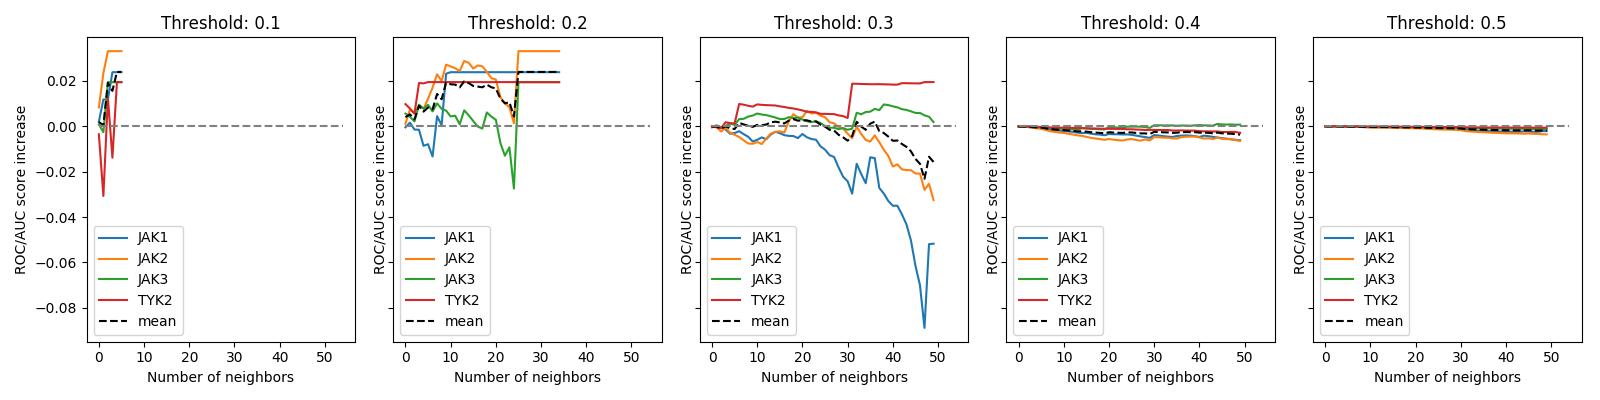

In [62]:
targets=['JAK1','JAK2','JAK3','TYK2']
from sklearn.metrics import roc_auc_score

plt.close()

f, axes = plt.subplots(1, 5, sharex = True, sharey=True, figsize=(16,4))


#colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for i,ax in enumerate(axes.flat):
  mean_ratios = []
  for name,target in zip(names,targets):
    trues = pd.read_csv('/dbfs/FileStore/tables/'+name+'-trues_bin76.csv')
    chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext',name+'-preds.csv'))
    df = trues.filter(['smiles',name]).merge(chemprop_preds.filter(['smiles',target]))
    #diffs.append(abs(np.array(df[name])-np.array(df[targets[i]])))
    fps = get_fps([Chem.MolFromSmiles(smi) for smi in df.smiles], bit=True)
    dists = fps_distances(fps)
    dists[dists==0]=1
    ratio = []
    for thresh in range(50):
      n_neighbors = np.sum(dists<(i+1)*0.1,axis=1)
      #n_true = diff_cp[(diff_cp.JAK1<0.5) & (n_neighbors>thresh)]
      #n_false = diff_cp[(diff_cp.JAK1>0.5) & (n_neighbors>thresh)]
      preds = df[target][n_neighbors>thresh]
      truevals = df[name][n_neighbors>thresh]
      try:
        ratio.append(roc_auc_score(truevals,preds)-roc_auc_score(df[name],df[target]))
      except:
        continue#ratio.append(0)
    ax.plot(range(len(ratio)),ratio,label=target)
    mean_ratios.append(ratio)
    #ax.set_xlim([0,55])
    #ax.set_ylim([-0.3,0.3])
  ax.plot(range(len(ratio)),np.mean(np.array(mean_ratios),axis=0),color='black',ls='--',label='mean')
  ax.plot(range(55),np.zeros(55),color='grey',ls='--')
  ax.set_title('Threshold: {:02.1f}'.format((i+1)*0.1))
  ax.set_xlabel('Number of neighbors')
  ax.set_ylabel('ROC/AUC score increase')
  #plt.axis([0,55,0.7,1.001])
  ax.legend()
plt.tight_layout()
display(plt.show())

### Binary prediction

In [64]:
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_binary.csv'),
                          '--checkpoint_path',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','binary-4x','model','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','binary-4x','model','fold_0/model_0/test_preds.csv')])
modify_predict_args(args)
make_predictions(args)

Loading training args
Loading data
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 3290.06it/s]
Validating SMILES
Test size = 183
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda

 0%| | 0/4 [00:00<?, ?it/s]
 75%|███████▌ | 3/4 [00:00<00:00, 28.53it/s]
100%|██████████| 4/4 [00:00<00:00, 30.98it/s]100%|██████████| 1/1 [00:02<00:00, 2.31s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/binary-4x/model/fold_0/model_0/test_preds.csv
Out[26]: 
[[0.0005128700868226588,
 0.00015196736785583198,
 1.6617885876257787e-06,
 5.619858711725101e-07],
 [0.2190067172050476,
 0.0390586331486702,
 0.001957789994776249,
 0.00018602256022859365],
 [0.7969126105308533,
 0.6684944033622742,
 0.015236832201480865,
 0.004957668017596006],
 [0.9132694005966187,
 0.9217473864555359,
 0.21086424589157104,
 0.0064592077396810055],
 [0.0068490272387862206,
 0.0032943019177764654,
 3.339870090712793e-05,
 8.165388862835243e-06],
 [0.010779643431305885,
 0.01954513229429722,
 0.0024906371254473925,
 0.0001404148933943361],
 [0.0209833774715662,
 0.032631948590278625,
 0.008278336375951767,
 0.0005981403519399464],
 [0.7709829807281494,
 0.7956750392913818,
 0.029872728511691093,
 0.004681069403886795],
 [0.9975852966308594,
 0.989043116569519,
 0.640504777431488,
 0.2239779829978943],
 [0.6351542472839355,
 0.5888552665710449,
 0.045101016759872437,
 0.0048145754262804985],
 [0.00043367242324166,
 0.0001614002976566553,
 6.930392828508047e-07,
 1.3103937135383603e-07],
 [0.667460024356842,
 0.7710250020027161,
 0.02485506236553192,
 0.001978896325454116],
 [0.1542903035879135,
 0.28968629240989685,
 0.01326699461787939,
 0.0015456480905413628],
 [0.24233011901378632,
 0.041341666132211685,
 0.0024679629132151604,
 0.0010113909374922514],
 [0.0025381080340594053,
 0.002432985929772258,
 1.880215495475568e-05,
 5.861415957042482e-06],
 [0.04648199304938316,
 0.06804268807172775,
 0.0009621008648537099,
 0.00010764262697193772],
 [0.1553841233253479,
 0.09932295978069305,
 0.0019962205551564693,
 0.0003539227764122188],
 [0.7816954255104065,
 0.801270604133606,
 0.06082118675112724,
 0.006340498570352793],
 [0.20430868864059448,
 0.121622733771801,
 0.0020100742112845182,
 0.0011937017552554607],
 [0.007352146785706282,
 0.019477542489767075,
 0.00015090777014847845,
 5.356611291063018e-05],
 [0.8355287909507751,
 0.872798502445221,
 0.3381950557231903,
 0.01699880138039589],
 [0.019772401079535484,
 0.031587857753038406,
 0.0005274334107525647,
 3.98871889046859e-05],
 [0.20347179472446442,
 0.13551613688468933,
 0.0035786700900644064,
 0.0005206021014600992],
 [0.9850760102272034,
 0.911613404750824,
 0.15694186091423035,
 0.032941609621047974],
 [0.16129255294799805,
 0.11265905946493149,
 0.001148352399468422,
 3.853790258290246e-05],
 [0.992225170135498,
 0.9729312062263489,
 0.4504210352897644,
 0.07195060700178146],
 [0.00023929160670377314,
 0.00041510461596772075,
 3.2197581276705023e-06,
 3.0796235250818427e-07],
 [0.06870619207620621,
 0.07917722314596176,
 0.00046444189501926303,
 0.0001055387983797118],
 [0.009578248485922813,
 0.005382736679166555,
 4.994314076611772e-05,
 7.808296686562244e-06],
 [0.0006946129142306745,
 0.0003659510985016823,
 3.980704605055507e-06,
 1.8052396626444533e-06],
 [0.8530596494674683,
 0.559244692325592,
 0.02397686056792736,
 0.006184426136314869],
 [0.8516318798065186,
 0.8481366038322449,
 0.02086547762155533,
 0.001028398983180523],
 [0.14614692330360413,
 0.18251767754554749,
 0.0010217742528766394,
 0.00012801392585970461],
 [0.7970317006111145,
 0.83277845

In [65]:
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--checkpoint_path',
                          os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/test_preds_bin76_ext.csv')])
modify_predict_args(args)
make_predictions(args)
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--checkpoint_path',
                          os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int','fold_0/model_0/test_preds_bin76_int.csv')])
modify_predict_args(args)
make_predictions(args)

Loading training args
Loading data
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 3091.79it/s]
Validating SMILES
Test size = 183
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/4 [00:00<?, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 41.63it/s]100%|██████████| 1/1 [00:01<00:00, 1.44s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext/fold_0/model_0/test_preds_bin76_ext.csv
Loading training args
Loading data
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 3126.37it/s]
Validating SMILES
Test size = 183
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/4 [00:00<?, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 44.14it/s]100%|██████████| 1/1 [00:01<00:00, 1.64s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_int/fold_0/model_0/test_preds_bin76_int.csv
Out[17]: 
[[0.06014738231897354,
 0.030724361538887024,
 0.0009406624594703317,
 8.45462091092486e-06],
 [0.772223711013794,
 0.585080623626709,
 0.11495141685009003,
 0.007724123541265726],
 [0.9712619781494141,
 0.9433736801147461,
 0.4703846275806427,
 0.08065924048423767],
 [0.9421650767326355,
 0.9384544491767883,
 0.7171423435211182,
 0.2871761918067932],
 [0.09993401169776917,
 0.04339313879609108,
 0.0037698058877140284,
 7.707404438406229e-05],
 [0.38971561193466187,
 0.6626189947128296,
 0.17335286736488342,
 0.025110894814133644],
 [0.2593590319156647,
 0.46042537689208984,
 0.07604837417602539,
 0.00885128602385521],
 [0.887377917766571,
 0.886754035949707,
 0.0908963605761528,
 0.015149186365306377],
 [0.988902747631073,
 0.9753164649009705,
 0.7379891276359558,
 0.40454190969467163],
 [0.9516304135322571,
 0.9390068054199219,
 0.2928336560726166,
 0.08970867097377777],
 [0.046683963388204575,
 0.02379547618329525,
 0.0007168896845541894,
 5.867109848622931e-06],
 [0.9425426721572876,
 0.9389627575874329,
 0.217233344912529,
 0.06679137051105499],
 [0.42954370379447937,
 0.4379112124443054,
 0.050689391791820526,
 0.002239322755485773],
 [0.9014804363250732,
 0.8011505007743835,
 0.11992793530225754,
 0.01878935471177101],
 [0.3793914020061493,
 0.3471786379814148,
 0.00773630989715457,
 0.0004238924302626401],
 [0.2612203061580658,
 0.27962028980255127,
 0.02337951585650444,
 0.0007447936804965138],
 [0.41220623254776,
 0.4018276035785675,
 0.018349600955843925,
 0.001066876808181405],
 [0.9291411638259888,
 0.9084290266036987,
 0.2941938638687134,
 0.031885914504528046],
 [0.40743905305862427,
 0.2920627295970917,
 0.016520945355296135,
 0.0010447034146636724],
 [0.19001919031143188,
 0.21801689267158508,
 0.0053452784195542336,
 0.0002000641979975626],
 [0.9832509160041809,
 0.9885502457618713,
 0.9493700265884399,
 0.8415719270706177],
 [0.06651124358177185,
 0.04974551126360893,
 0.002192542189732194,
 1.1601034202612936e-05],
 [0.6125721335411072,
 0.6621711254119873,
 0.012666256166994572,
 0.0010945700341835618],
 [0.9912341237068176,
 0

In [66]:
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--checkpoint_path',
                          os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/val_preds_bin76_ext.csv')])
modify_predict_args(args)
make_predictions(args)
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'),
                          '--checkpoint_path',
                          os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int','fold_0/model_0/val_preds_bin76_int.csv')])
modify_predict_args(args)
make_predictions(args)

Loading training args
Loading data


 0%| | 0/182 [00:00<?, ?it/s]

100%|██████████| 182/182 [00:00<00:00, 3166.01it/s]Validating SMILES
Test size = 182
Predicting with an ensemble of 1 models


 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda



 0%| | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 45.09it/s]

100%|██████████| 1/1 [00:01<00:00, 1.41s/it]Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext/fold_0/model_0/val_preds_bin76_ext.csv
Loading training args
Loading data


 0%| | 0/182 [00:00<?, ?it/s]

100%|██████████| 182/182 [00:00<00:00, 3204.80it/s]Validating SMILES
Test size = 182
Predicting with an ensemble of 1 models


 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda



 0%| | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 45.16it/s]

100%|██████████| 1/1 [00:01<00:00, 1.38s/it]Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_int/fold_0/model_0/val_preds_bin76_int.csv
Out[34]: 
[[0.4778834283351898,
 0.2351142168045044,
 0.007805065717548132,
 0.0004002431232947856],
 [0.03284074366092682,
 0.04740620777010918,
 0.000313765078317374,
 5.6528479035478085e-06],
 [0.04585736617445946,
 0.034592997282743454,
 0.001045508892275393,
 1.9468636310193688e-05],
 [0.05815904214978218,
 0.006437425501644611,
 0.0035113997291773558,
 1.0830783139681444e-05],
 [0.9649506211280823,
 0.8321712017059326,
 0.3615501821041107,
 0.012894111685454845],
 [0.0661563128232956,
 0.0464491993188858,
 0.0019046184606850147,
 7.04408303136006e-05],
 [0.0718972310423851,
 0.1163259819149971,
 0.009049229323863983,
 0.00012653139128815383],
 [0.7602165937423706,
 0.757743239402771,
 0.1899527907371521,
 0.05215475708246231],
 [4.556955346401992e-08,
 1.9405180240461561e-10,
 3.996944268613856e-12,
 2.00706263724557e-19],
 [0.24257752299308777,
 0.21546240150928497,
 0.04785468801856041,
 0.0037942249327898026],
 [0.8603323698043823,
 0.8819162845611572,
 0.04697493836283684,
 0.008587494492530823],
 [0.07700617611408234,
 0.015868637710809708,
 0.0027585141360759735,
 2.907989255618304e-05],
 [0.07770708203315735,
 0.006004742346704006,
 0.0016848527593538165,
 4.093422376172384e-06],
 [0.014134641736745834,
 0.005018272902816534,
 0.0003526764048729092,
 3.8029320421628654e-06],
 [0.2890487015247345,
 0.11011975258588791,
 0.0025885358918458223,
 0.00015067226195242256],
 [0.005838701035827398,
 0.0011972887441515923,
 0.0002043053973466158,
 1.8857957684303983e-07],
 [0.7659364938735962,
 0.633080780506134,
 0.020032614469528198,
 0.002250009449198842],
 [0.9889636039733887,
 0.9761629104614258,
 0.7116623520851135,
 0.25621911883354187],
 [0.9543026089668274,
 0.9345523118972778,
 0.2982119023799896,
 0.1049564778804779],
 [0.9311882853507996,
 0.6498689651489258,
 0.5723152160644531,
 0.13355381786823273],
 [0.06606392562389374,
 0.06308254599571228,
 0.006907637696713209,
 4.737100607599132e-05],
 [0.011669503524899483,
 0.005099525209516287,
 0.00016527852858416736,
 5.91790410453541e-07],
 [0.06489400565624237,
 0.01148481480

In [67]:
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--checkpoint_path',
                          os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext_Feat_SLogP','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext_Feat_SLogP','fold_0/model_0/test_preds_bin76_ext_Feat_SLogP.csv')])
modify_predict_args(args)
make_predictions(args)
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--checkpoint_path',
                          os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int_Feat_SLogP','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_int_Feat_SLogP','fold_0/model_0/test_preds_bin76_int_Feat_SLogP.csv')])
modify_predict_args(args)
make_predictions(args)


Loading training args
Loading data
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 2833.63it/s]
Validating SMILES
Test size = 183
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda

 0%| | 0/4 [00:00<?, ?it/s]
 75%|███████▌ | 3/4 [00:00<00:00, 28.71it/s]
100%|██████████| 4/4 [00:00<00:00, 31.45it/s]100%|██████████| 1/1 [00:02<00:00, 2.85s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_ext_Feat_SLogP/fold_0/model_0/test_preds_bin76_ext_Feat_SLogP.csv
Loading training args
Loading data
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 2890.50it/s]
Validating SMILES
Test size = 183
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda

 0%| | 0/4 [00:00<?, ?it/s]
 75%|███████▌ | 3/4 [00:00<00:00, 28.13it/s]
100%|██████████| 4/4 [00:00<00:00, 30.68it/s]100%|██████████| 1/1 [00:02<00:00, 2.50s/it]
Saving predictions to /dbfs/FileStore/chemprop/JAK/hyperopt_4x-bin76_int_Feat_SLogP/fold_0/model_0/test_preds_bin76_int_Feat_SLogP.csv
Out[19]: 
[[0.021509801968932152,
 0.009683476760983467,
 0.0005746048991568387,
 3.049027691304218e-05],
 [0.494133859872818,
 0.2800716757774353,
 0.024666771292686462,
 0.001775816548615694],
 [0.8795645236968994,
 0.7977457642555237,
 0.23091095685958862,
 0.018174413591623306],
 [0.9304183125495911,
 0.8870624303817749,
 0.5983377695083618,
 0.12444499135017395],
 [0.11076237261295319,
 0.037804752588272095,
 0.005893657449632883,
 0.0005669749225489795],
 [0.2605248987674713,
 0.42928799986839294,
 0.0856688916683197,
 0.009336891584098339],
 [0.2584491968154907,
 0.36287668347358704,
 0.050967417657375336,
 0.006813549902290106],
 [0.8944602012634277,
 0.8386507034301758,
 0.0691104605793953,
 0.012074950151145458],
 [0.9823343753814697,
 0.9421291947364807,
 0.5253525376319885,
 0.15982869267463684],
 [0.9107779264450073,
 0.8538690805435181,
 0.1533123254776001,
 0.046223245561122894],
 [0.014247865416109562,
 0.004729895386844873,
 0.00030305833206512034,
 1.4242899851524271e-05],
 [0.8190213441848755,
 0.7976062893867493,
 0.06677927076816559,
 0.017885765060782433],
 [0.41819071769714355,
 0.39270609617233276,
 0.07426220923662186,
 0.004441095981746912],
 [0.7161812782287598,
 0.46724799275398254,
 0.03640718385577202,
 0.004011727869510651],
 [0.06220848485827446,
 0.08098039776086807,
 0.0018145465292036533,
 0.00019775042892433703],
 [0.45990970730781555,
 0.3914739191532135,
 0.04663348197937012,
 0.00351711711846292],
 [0.5080682635307312,
 0.4324767589569092,
 0.021859586238861084,
 0.0031127852853387594],
 [0.8240869045257568,
 0.7521774768829346,
 0.17670311033725739,
 0.012494317255914211],
 [0.28984975814819336,
 0.2190825343132019,
 0.01471368782222271,
 0.0022151805460453033],
 [0.18584533035755157,
 0.2185235321521759,
 0.00857454165816307,
 0.0009881322039291263],
 [0.9616071581840515,
 0.9637580513954163,
 0.9203590750694275,
 0.6423345804214478],
 [0.13403698801994324,
 0.1141287311911583,
 0.014197123236954212,
 0.0006980433827266097],
 [0.5112892389297485,
 0.4583916664123535,
 0.005827958229929209,
 0.001508526154793799],
 [0.9813661575317383,
 0.9461495280265808,
 

# Unused material

### Regression hyperparameter tuning with SLogP Feature

In [70]:
parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=20,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
if not os.path.exists(os.path.join(CHEMPROP_DIR,'JAK','checkpoints','Feat_SLogP')):
  os.mkdir(os.path.join(CHEMPROP_DIR,'JAK','checkpoints','Feat_SLogP'))

args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtrain-1460.csv'),
                          '--dataset_type','regression',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','Feat_SLogP'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182.csv'),
                          '--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'),
                          '--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--config_save_path',os.path.join(CHEMPROP_DIR,'JAK','Feat_SLogP','regression-4x.json'),
                          '--log_dir',os.path.join(CHEMPROP_DIR,'JAK','Feat_SLogP')])
modify_train_args(args)

grid_search(args)

0%| | 0/20 [00:00<?, ?it/s, best loss: ?]{'depth': 4, 'dropout': 0.25, 'ffn_num_layers': 3, 'hidden_size': 1400}
{'depth': 4, 'dropout': 0.25, 'ffn_num_layers': 3, 'hidden_size': 1400}
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/Feat_SLogP/regression-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460.csv',
 'dataset_type': 'regression',
 'depth': 4,
 'dropout': 0.25,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1400,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/Feat_SLogP',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 20,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/Feat_SLogP/depth_4_dropout_0.25_ffn_num_layers_3_hidden_size_1400/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/JAK/Feat_SLogP/regression-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460.csv',
 'dataset_type': 'regression',
 'depth': 4,
 'dropout': 0.25,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1400,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/JAK/Feat_SLogP',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_iters': 20,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/Feat_SLogP/depth_4_dropout_0.25_ffn_num_layers_3_hidden_size_1400/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,


In [71]:
%sh cp /dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv /dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv 
sed 1d /dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv >> /dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv 
sed 1d /dbfs/FileStore/chemprop/JAK/SLogPval-182.csv >> /dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv 
wc /dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv 

1826 1826 32188 /dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv

#### SLogP 10-fold CV - all data

In [73]:

parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=20,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
if not os.path.exists(os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP')):
  os.mkdir(os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP'))

args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPall-1825.csv'),
                          '--dataset_type','regression',
                          '--save_dir',os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP'),
                          #'--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182.csv'),
                          #'--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          #'--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'),
                          #'--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--config_save_path',os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP','regression-4x.json'),
                          '--log_dir',os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP'),
                          '--save_smiles_splits',
                          '--split_type','scaffold_balanced',
                          '--num_folds','10',
                          '--seed','13'
                          ])
modify_train_args(args)

grid_search(args)

0%| | 0/20 [00:00<?, ?it/s, best loss: ?]{'depth': 2, 'dropout': 0.15000000000000002, 'ffn_num_layers': 2, 'hidden_size': 1800}
{'depth': 2, 'dropout': 0.15000000000000002, 'ffn_num_layers': 2, 'hidden_size': 1800}
{'depth': 2, 'dropout': 0.15000000000000002, 'ffn_num_layers': 2, 'hidden_size': 1800}
Fold 0
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP/regression-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/all-1825.csv',
 'dataset_type': 'regression',
 'depth': 2,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1800,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 10,
 'num_iters': 20,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP/depth_2_dropout_0.15000000000000002_ffn_num_layers_2_hidden_size_1800/fold_0',
 'save_smiles_splits': True,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP/regression-4x.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/all-1825.csv',
 'dataset_type': 'regression',
 'depth': 2,
 'dropout': 0.15000000000000002,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1800,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 10,
 'num_iters': 20,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP/depth_2_dropout_0.15000000000000002_ffn_num_layers_2_hidden_size_1800/fold_0',
 'save_smiles_splits': True,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPall-1825.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP/regression-4x.json',
 'cuda': True,
 'data_pa

In [74]:
%sh ls /dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP

depth_2_dropout_0.05_ffn_num_layers_1_hidden_size_2100
depth_2_dropout_0.15000000000000002_ffn_num_layers_2_hidden_size_1000
depth_2_dropout_0.15000000000000002_ffn_num_layers_2_hidden_size_1800
depth_3_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_1600
depth_3_dropout_0.1_ffn_num_layers_3_hidden_size_300
depth_3_dropout_0.1_ffn_num_layers_3_hidden_size_700
depth_3_dropout_0.25_ffn_num_layers_2_hidden_size_1500
depth_3_dropout_0.25_ffn_num_layers_2_hidden_size_700
depth_3_dropout_0.30000000000000004_ffn_num_layers_1_hidden_size_1700
depth_3_dropout_0.4_ffn_num_layers_1_hidden_size_1200
depth_4_dropout_0.0_ffn_num_layers_2_hidden_size_1200
depth_4_dropout_0.15000000000000002_ffn_num_layers_2_hidden_size_600
depth_4_dropout_0.15000000000000002_ffn_num_layers_3_hidden_size_1900
depth_4_dropout_0.25_ffn_num_layers_2_hidden_size_1000
depth_4_dropout_0.25_ffn_num_layers_3_hidden_size_2200
depth_4_dropout_0.2_ffn_num_layers_2_hidden_size_2000
depth_4_dropout_0.30000000000000004_ffn_num_layers_2_hidden_size_1100
depth_4_dropout_0.35000000000000003_ffn_num_layers_2_hidden_size_1500
depth_4_dropout_0.4_ffn_num_layers_2_hidden_size_1500
depth_4_dropout_0.4_ffn_num_layers_3_hidden_size_1200
depth_6_dropout_0.0_ffn_num_layers_2_hidden_size_1900
depth_6_dropout_0.4_ffn_num_layers_1_hidden_size_2200
fold_0
fold_1
fold_2
fold_3
fold_4
fold_5
fold_6
fold_7
fold_8
fold_9
quiet.log
regression-4x.json
verbose.log

### HLM Regression hyperparameter tuning

In [76]:
data = os.path.join(CHEMPROP_DIR,'hlm_eh.csv')

In [77]:
data = os.path.join(CHEMPROP_DIR,'hlm_eh.csv')
parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=30,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
args = parser.parse_args(['--data_path',data,
                          '--dataset_type','regression',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'HLM','checkpoints'),
                          '--config_save_path',os.path.join(CHEMPROP_DIR,'HLM','configs','regression-HLM_Eh.json'),
                          '--log_dir',os.path.join(CHEMPROP_DIR,'HLM','configs'),
                          '--save_smiles_splits',
                          '--split_type','scaffold_balanced',
                          '--num_folds','5'])
modify_train_args(args)

grid_search(args)

0%| | 0/30 [00:00<?, ?it/s, best loss: ?]{'depth': 4, 'dropout': 0.05, 'ffn_num_layers': 2, 'hidden_size': 1100}
{'depth': 4, 'dropout': 0.05, 'ffn_num_layers': 2, 'hidden_size': 1100}
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/HLM/configs/regression-HLM_Eh.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/hlm_eh.csv',
 'dataset_type': 'regression',
 'depth': 4,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1100,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/HLM/configs',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 5,
 'num_iters': 30,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/HLM/checkpoints/depth_4_dropout_0.05_ffn_num_layers_2_hidden_size_1100/fold_0',
 'save_smiles_splits': True,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'config_save_path': '/dbfs/FileStore/chemprop/HLM/configs/regression-HLM_Eh.json',
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/hlm_eh.csv',
 'dataset_type': 'regression',
 'depth': 4,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 300,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1100,
 'init_lr': 0.0001,
 'log_dir': '/dbfs/FileStore/chemprop/HLM/configs',
 'log_frequency': 10,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 5,
 'num_iters': 30,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/HLM/checkpoints/depth_4_dropout_0.05_ffn_num_layers_2_hidden_size_1100/fold_0',
 'save_smiles_splits': True,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
Loading data

  0%| | 0/804 [00:00<?, ?it/s]

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
 

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
  29%|##9 | 237/804 [00:00<00:00, 2366.45it/s]

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
 

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
  56%|#####6 | 451/804 [00:00<00:00, 2290.88it/s]

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
 

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
  78%|#######7 | 625/804 [00:00<00:00, 2090.88it/s]

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
 

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
 100%|#########9| 802/804 [00:00<00:00, 1982.70it/s]

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
 

 0%| | 0/30 [00:00<?, ?it/s, best loss: ?]
 100%|##########| 804/804 [00:00<00:00, 2000.75it/s]

 0%| |

In [78]:
%sh cat /dbfs/FileStore/chemprop/HLM/configs/regression-HLM_Eh.json

{
 "depth": 6,
 "dropout": 0.0,
 "ffn_num_layers": 1,
 "hidden_size": 1900
}

# HLM Classification hyperparameter tuning

In [80]:
hlm_dataset = pd.read_csv('/dbfs/FileStore/tables/HLM_dataset_Series_B.csv',sep=';')
hlm_dataset = hlm_dataset.filter(['SMILES','HLM Eh% 1065']).rename(columns={'SMILES':'smiles','HLM Eh% 1065':'HLM_Eh%'})
hlm_dataset.to_csv(os.path.join(CHEMPROP_DIR,'hlm_eh.csv'),index=False)
hlm_dataset['HLM_binary'] = hlm_dataset['HLM_Eh%'].apply(lambda x: 1 if x > 33 else 0)
hlm_dataset['HLM_ternary'] = hlm_dataset['HLM_Eh%'].apply(lambda x: 0 if x < 33 else x)
hlm_dataset['HLM_ternary'] = hlm_dataset['HLM_ternary'].apply(lambda x: 1 if (x >= 33 and x < 66) else x)
hlm_dataset['HLM_ternary'] = hlm_dataset['HLM_ternary'].apply(lambda x: 2 if x >= 66 else x)
hlm_dataset.filter(['smiles','HLM_binary']).to_csv(os.path.join(CHEMPROP_DIR,'hlm_eh_binary.csv'),index=None,float_format='%.0f')
hlm_dataset.filter(['smiles','HLM_ternary']).to_csv(os.path.join(CHEMPROP_DIR,'hlm_eh_ternary.csv'),index=None,float_format='%.0f')

In [81]:
data = os.path.join(CHEMPROP_DIR,'hlm_eh_binary.csv')
parser = ArgumentParser()
add_train_args(parser)
parser.add_argument('--num_iters', type=int, default=30,
                    help='Number of hyperparameter choices to try')
parser.add_argument('--config_save_path', type=str, required=True,
                    help='Path to .json file where best hyperparameter settings will be written')
parser.add_argument('--log_dir', type=str,
                    help='(Optional) Path to a directory where all results of the hyperparameter optimization will be written')
args = parser.parse_args(['--data_path',data,
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'HLM','checkpoints'),
                          '--config_save_path',os.path.join(CHEMPROP_DIR,'HLM','configs','classification-HLM_Eh.json'),
                          '--log_dir',os.path.join(CHEMPROP_DIR,'HLM','configs'),
                          '--save_smiles_splits',
                          '--split_type','scaffold_balanced'#,
                          #'--num_folds','5'
                         ])
modify_train_args(args)

grid_search(args)

In [82]:
os.listdir(os.path.join(CHEMPROP_DIR,'HLM','checkpoints'))

Out[8]: 
['depth_2_dropout_0.0_ffn_num_layers_1_hidden_size_1700',
 'depth_2_dropout_0.15000000000000002_ffn_num_layers_1_hidden_size_1900',
 'depth_3_dropout_0.05_ffn_num_layers_3_hidden_size_500',
 'depth_3_dropout_0.1_ffn_num_layers_1_hidden_size_600',
 'depth_3_dropout_0.25_ffn_num_layers_3_hidden_size_1300',
 'depth_3_dropout_0.2_ffn_num_layers_2_hidden_size_1900',
 'depth_3_dropout_0.30000000000000004_ffn_num_layers_2_hidden_size_900',
 'depth_3_dropout_0.35000000000000003_ffn_num_layers_2_hidden_size_2200',
 'depth_3_dropout_0.35000000000000003_ffn_num_layers_2_hidden_size_2400',
 'depth_4_dropout_0.05_ffn_num_layers_2_hidden_size_1100',
 'depth_4_dropout_0.15000000000000002_ffn_num_layers_2_hidden_size_2200',
 'depth_4_dropout_0.1_ffn_num_layers_1_hidden_size_2400',
 'depth_4_dropout_0.4_ffn_num_layers_2_hidden_size_1500',
 'depth_5_dropout_0.05_ffn_num_layers_2_hidden_size_1200',
 'depth_5_dropout_0.05_ffn_num_layers_2_hidden_size_800',
 'depth_5_dropout_0.1_ffn_num_layers_2_hidden_size_1200',
 'depth_5_dropout_0.25_ffn_num_layers_3_hidden_size_1000',
 'depth_5_dropout_0.25_ffn_num_layers_3_hidden_size_2100',
 'depth_5_dropout_0.2_ffn_num_layers_1_hidden_size_1400',
 'depth_5_dropout_0.2_ffn_num_layers_3_hidden_size_400',
 'depth_5_dropout_0.30000000000000004_ffn_num_layers_2_hidden_size_1900',
 'depth_6_dropout_0.05_ffn_num_layers_2_hidden_size_400',
 'depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_1600',
 'depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_1700',
 'depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_1900',
 'depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_2000',
 'depth_6_dropout_0.15000000000000002_ffn_num_layers_1_hidden_size_1200',
 'depth_6_dropout_0.1_ffn_num_layers_1_hidden_size_1900',
 'depth_6_dropout_0.2_ffn_num_layers_1_hidden_size_700',
 'fold_0',
 'fold_1',
 'fold_2',
 'fold_3',
 'fold_4',
 'quiet.log',
 'verbose.log']

### HLM Regression

In [84]:
#{ "depth": 6, "dropout": 0.0, "ffn_num_layers": 1, "hidden_size": 1900 }
parser = ArgumentParser()
add_train_args(parser)

args = parser.parse_args(['--data_path',data,
                          '--dataset_type','regression',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'HLM','checkpoints'),
                          '--log_frequency','1',
                          '--save_smiles_splits',
                          '--split_type','scaffold_balanced',
                          '--depth','6',
                          '--dropout','0.0',
                          '--hidden_size','1900',
                          '--ffn_num_layers','2',
                          '--num_folds','5',
                          '--seed','13',
                          '--epochs','25',
                          '--ensemble_size','10'
                         ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)

Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/hlm_eh.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.0,
 'ensemble_size': 10,
 'epochs': 25,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 1900,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1900,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 5,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/HLM/checkpoints/fold_0',
 'save_smiles_splits': True,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/hlm_eh.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.0,
 'ensemble_size': 10,
 'epochs': 25,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 1900,
 'ffn_num_layers': 2,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 1900,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 5,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/HLM/checkpoints/fold_0',
 'save_smiles_splits': True,
 'seed': 13,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
Loading data

 0%| | 0/804 [00:00<?, ?it/s]
 33%|███▎ | 263/804 [00:00<00:00, 2619.65it/s]
 60%|██████ | 484/804 [00:00<00:00, 2479.50it/s]
 83%|████████▎ | 664/804 [00:00<00:00, 2227.03it/s]
100%|██████████| 804/804 [00:00<00:00, 2103.38it/s]Warning: 2 SMILES are invalid.
Warning: 2 SMILES are invalid.
Number of tasks = 1
Number of tasks = 1
Splitting data with seed 13
Splitting data with seed 13

 0%| | 0/802 [00:00<?, ?it/s]
 27%|██▋ | 213/802 [00:00<00:00, 2126.85it/s]
 51%|█████ | 408/802 [00:00<00:00, 2067.69it/s]
 70%|███████ | 562/802 [00:00<00:00, 1871.10it/s]
 89%|████████▉ | 715/802 [00:00<00:00, 1749.86it/s]
100%|██████████| 802/802 [00:00<00:00, 1729.99it/s]Total scaffolds = 310 | train scaffolds = 252 | val scaffolds = 21 | test scaffolds = 37
Total scaffolds = 310 | train scaffolds = 252 | val scaffolds = 21 | test scaffolds = 37
Label averages per scaffold, in decreasing order of scaffold frequency,capped at 10 scaffolds and 20 labels: [(array([92.]), array([2])), (array([51.71428571]), array([7])), (array([86.]), array([1])), (array([87.]), array([1])), (array([94.]), array([2])), (array([37.]), array([1])), (array([88.]), array([2])), (array([90.]), array([1])), (array([28.]), array([1])), (array([52.]), array([1]))]
Label averages per scaffold, in decreasing order of scaffold frequency,capped at 10 scaffolds and 20 labels: [(array([92.]), array(

#### Testing different features

In [86]:
# Test RMSE
#Ensemble-10: 0.44
#Ensemble-3: 0.52
#Feature morgan_count: 0.60
#Feature morgan: 0.62
#Feature BalabanJ: 0.54
#Feature AATS0dv: 0.53
#Feature AATSC5d: 0.53
#Feature ABC: 0.53
#Feature ECIndex: 0.53
#Feature SLogP: 0.51 best: {'depth': 6, 'dropout': 0.0, 'ffn_num_layers': 3, 'hidden_size': 400}
#%tb
parser = ArgumentParser()
add_train_args(parser)
if not os.path.exists(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x')):
  os.mkdir(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x'))
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'),#os.path.join(CHEMPROP_DIR,'JAK','all_1825-regression.csv'),#os.path.join(CHEMPROP_DIR,'JAK','train-1460.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtrain-sparse.csv'),
                          '--dataset_type','regression',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-2188-sparse-regression-scaffold-FeatSlogP'),
                          #'--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182.csv'),
                          #'--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          #'--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183.csv'),
                          #'--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--log_frequency','1',
                          '--depth','6',#'4',
                          '--dropout','0.0',#'0.1',
                          '--hidden_size','400',#'2000',
                          '--ffn_num_layers','3'#'2'
                        #,'--atom_messages'
                        ,'--ensemble_size','5'
                        ,'--split_type','scaffold_balanced'
                        #,'--features_generator','rdkit_2d'
                        #,'--seed','13',
                          ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)
#sparse ensemble (5):0.538572
#sparse ensemble (5) SLogP:0.513054

Fold 0
Fold 0
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/all_2188-sparse-regression.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.0,
 'ensemble_size': 5,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-sparse.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 400,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 400,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-2188-sparse-regression-scaffold-FeatSlogP/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-sparse.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/all_2188-sparse-regression.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.0,
 'ensemble_size': 5,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-sparse.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 400,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 400,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-2188-sparse-regression-scaffold-FeatSlogP/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'scaffold_balanced',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-sparse.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/all_2188-sparse-regression.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.0,
 'ensemble_size': 5,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-sparse.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 400,
 'ffn_num_layers': 3,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 400,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-2188-sparse-regression-scaffold-FeatSlogP/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separa

In [87]:
os.listdir(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-2188-sparse-regression-scaffold','fold_0','model_1'))

Out[20]: 
['events.out.tfevents.1566149717.0308-155047-pad750-10-139-64-4',
 'events.out.tfevents.1566150883.0308-155047-pad750-10-139-64-4',
 'model.pt']

### Classification 4x training

In [89]:
%sh cat /dbfs/FileStore/chemprop/JAK/configs/binary-4x.json

{
 "depth": 6,
 "dropout": 0.30000000000000004,
 "ffn_num_layers": 1,
 "hidden_size": 2200
}

In [90]:
parser = ArgumentParser()
add_train_args(parser)
if not os.path.exists(ZINC_Models):
  os.mkdir(os.path.join(CHEMPROP_DIR,'JAK','checkpoints','binary-4x','model'))
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460_binary.csv'),
                         '--dataset_type','classification',
                         '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','binary-4x','model'),
                         '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_binary.csv'),
                         '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_binary.csv'),
                         '--log_frequency','1',
                         '--depth','6',
                         '--dropout','0.3',
                         '--hidden_size','2200',
                         '--ffn_num_layers','1'
                         ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)

Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_binary.csv',
 'dataset_type': 'classification',
 'depth': 6,
 'dropout': 0.3,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/binary-4x/model/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_binary.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_binary.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_binary.csv',
 'dataset_type': 'classification',
 'depth': 6,
 'dropout': 0.3,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/binary-4x/model/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_binary.csv',
 'separate_val_features_path': None,
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_binary.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
Loading data
 0%| | 0/1460 [00:00<?, ?it/s] 23%|██▎ | 343/1460 [00:00<00:00, 3424.96it/s] 47%|████▋ | 686/1460 [00:00<00:00, 3423.48it/s] 70%|██████▉ | 1021/1460 [00:00<00:00, 3399.40it/s] 93%|█████████▎| 1356/1460 [00:00<00:00, 3381.48it/s]100%|██████████| 1460/1460 [00:00<00:00, 3378.01it/s]
Number of tasks = 4
Number of tasks = 4
Splitting data with seed 0
Splitting data with seed 0
 0%| | 0/183 [00:00<?, ?it/s]100%|██████████| 183/183 [00:00<00:00, 3362.44it/s]
 0%| | 0/182 [00:00<?, ?it/s]100%|██████████| 182/182 [00:00<00:00, 3343.74it/s]
Class sizes
Class sizes
JAK1 EC50 nM 1027 0: 68.56%, 1: 31.44%
JAK1 EC50 nM 1027 0: 68.56%, 1: 31.44%
JAK2 EC50 nM 1024 0: 72.40%, 1: 27.60%
JAK2 EC50 nM 1024 0: 72.40%, 1: 27.60%
JAK3 EC50 nM 1026 0: 93.15%, 1: 6.85%
JAK3 EC50 nM 1026 0: 93.15%, 1: 6.85%
TYK2 EC50 nM 1025 0: 98.08%, 1: 1.92%
TYK2 EC50 nM 1025 0: 98.08%, 1: 1.92%
Total size = 1,460 | train size = 1,460 | val size = 182 | test size = 183
Total size = 1,460 | train size = 1,460 | val size = 182 | test size = 183
Building model 0
Building model 0
MoleculeModel(
 (sigmoid): Sigmoid()
 (encoder): MPN(
 (encoder): MPNEncoder(
 (dropout_laye

#### Classification 4x training different mods

In [92]:

#Feature SLogP: 

parser = ArgumentParser()
add_train_args(parser)
if not os.path.exists(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x')):
  os.mkdir(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x'))
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'JAK','train-1460_binary.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtrain-1460.csv'),
                          '--dataset_type','classification',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-mods-bin'),
                          '--separate_val_path',os.path.join(CHEMPROP_DIR,'JAK','val-182_binary.csv'),
                          '--separate_val_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPval-182.csv'),
                          '--separate_test_path',os.path.join(CHEMPROP_DIR,'JAK','test-183_binary.csv'),
                          '--separate_test_features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPtest-183.csv'),
                          '--log_frequency','1',
                          '--depth','6',
                          '--dropout','0.3',
                          '--hidden_size','2200',
                          '--ffn_num_layers','1'
                        #,'--atom_messages'
                        #,'--ensemble_size','3'
                        #,'--features_generator','rdkit_2d'
                        #,'--seed','13',
                          ])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)

cross_validate(args, logger)

Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
Fold 0
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_binary.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.3,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-mods-bin/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_binary.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_binary.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_binary.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.3,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'rmse',
 'minimize_score': True,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/hyperopt_4x-mods-bin/fold_0',
 'save_smiles_splits': False,
 'seed': 0,
 'separate_test_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtest-183.csv'],
 'separate_test_path': '/dbfs/FileStore/chemprop/JAK/test-183_binary.csv',
 'separate_val_features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPval-182.csv'],
 'separate_val_path': '/dbfs/FileStore/chemprop/JAK/val-182_binary.csv',
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'ReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/JAK/train-1460_binary.csv',
 'dataset_type': 'regression',
 'depth': 6,
 'dropout': 0.3,
 'ensemble_size': 1,
 'epochs': 30,
 'features_generator': None,
 'features_only': False,
 'features_path': ['/dbfs/FileStore/chemprop/JAK/SLogPtrain-1460.csv'],
 'features_scaling': True,
 'ffn_hidden_size': 2200,
 'ffn_num_layers': 1,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2200,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,


In [93]:
%sh head /dbfs/FileStore/chemprop/JAK/all-1825.csv

smiles,JAK1 EC50 nM 1027,JAK2 EC50 nM 1024,JAK3 EC50 nM 1026,TYK2 EC50 nM 1025
Cc1c[nH]c(C(=O)N2CCCN(c3ncnc4[nH]ccc34)CC23CC3)c1,7.856985199745905,7.94692155651658,6.886056647693163,6.82102305270683
O=S(=O)(N(CCN1CCOCC1)C1CCC1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2,7.069560405233299,7.357535479757878,6.33161408331,6.157390760389438
CN(C[C@@H]1CCCN1S(C)(=O)=O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2,7.732828271596986,7.8326826652518236,6.966576244513051,6.376750709602099
CC(=O)N1CC[C@H]1COC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2,6.7544873321858505,6.665546248849069,6.244887733604929,5.379863945026242
N#Cc1ccc(CC(=O)N2CCN(c3ncnc4[nH]ccc34)C3(CC3)C2)cc1,6.504455662453552,6.1487416512809245,5.782516055786093,5.235077015350112
O=C(OC1CCC(O)C1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2,7.476253533188435,7.26440110030182,6.46344155742847,6.136677139879544
CC(C)COC(=O)N1CCC[C@@H]1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2,7.52432881167557,7.153044674980176,6.045757490560675,5.906578314837765
N#CCCNC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2,7.1732774798310075,6.987162775294828,6.350665141287858,5.841637507904751
C[C@@H](OC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2)c1c(F)cccc1F,6.134896025358872,5.94692155651658,5.359518563029578,5.046240308266771

In [94]:
#{'depth': 6, 'dropout': 0.0, 'ffn_num_layers': 2, 'hidden_size': 1900}
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv'),
                          '--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPall-1825.csv'),
                          '--checkpoint_path',os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP','fold_0/model_0/model.pt'),
                          '--preds_path',os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP','fold_0/model_0/all-1825_preds.csv')])
modify_predict_args(args)
make_predictions(args)

Loading training args
Loading data
 0%| | 0/1825 [00:00<?, ?it/s] 16%|█▌ | 287/1825 [00:00<00:00, 2865.89it/s] 31%|███▏ | 571/1825 [00:00<00:00, 2857.78it/s] 47%|████▋ | 850/1825 [00:00<00:00, 2833.62it/s] 62%|██████▏ | 1130/1825 [00:00<00:00, 2822.68it/s] 77%|███████▋ | 1412/1825 [00:00<00:00, 2819.13it/s] 90%|█████████ | 1646/1825 [00:00<00:00, 2171.08it/s]100%|██████████| 1825/1825 [00:00<00:00, 2504.10it/s]
Validating SMILES
Test size = 1,825
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/37 [00:00<?, ?it/s]
 5%|▌ | 2/37 [00:00<00:02, 14.03it/s]
 8%|▊ | 3/37 [00:00<00:02, 11.97it/s]
 11%|█ | 4/37 [00:00<00:03, 10.70it/s]
 14%|█▎ | 5/37 [00:00<00:03, 9.89it/s]
 16%|█▌ | 6/37 [00:00<00:03, 9.51it/s]
 19%|█▉ | 7/37 [00:00<00:03, 9.46it/s]
 22%|██▏ | 8/37 [00:00<00:03, 9.25it/s]
 24%|██▍ | 9/37 [00:00<00:03, 9.15it/s]
 27%|██▋ | 10/37 [00:01<00:02, 9.02it/s]
 30%|██▉ | 11/37 [00:01<00:03, 6.97it/s]
 32%|███▏ | 12/37 [00:01<00:03, 7.45it/s]
 35%|███▌ | 13/37 [00:01<00:03, 7.87it/s]
 38%|███▊ | 14/37 [00:01<00:02, 8.22it/s]
 41%|████ | 15/37 [00:01<00:02, 8.19it/s]
 43%|████▎ | 16/37 [00:01<00:02, 8.19it/s]
 46%|████▌ | 17/37 [00:01<00:02, 8.12it/s]
 49%|████▊ | 18/37 [00:02<00:02, 8.37it/s]
 51%|█████▏ | 19/37 [00:02<00:02, 8.70it/s]
 54%|█████▍ | 20/37 [00:02<00:01, 8.80it/s]
 57%|█████▋ | 21/37 [00:02<00:01, 8.48it/s]
 59%|█████▉ | 22/37 [00:02<00:02, 6.06it/s]
 62%|██████▏ | 23/37 [00:02<00:02, 6.65it/s]
 65%|██████▍ | 24/37 [00:02<00:01, 7.12it/s]
 68%|██████▊ | 25/37 [00:03<00:01, 7.61it/s]
 70%|███████ | 26/37 [00:03<00:01, 8.06it/s]
 73%|███████▎ | 27/37 [00:03<00:01, 8.16it/s]
 76%|███████▌ | 28/37 [00:03<00:01, 7.98it/s]
 78%|███████▊ | 29/37 [00:03<00:00, 8.22it/s]
 81%|████████ | 30/37 [00:03<00:00, 8.46it/s]
 84%|████████▍ | 31/37 [00:03<00:00, 8.58it/s]
 86%|████████▋ | 32/37 [00:03<00:00, 8.55it/s]
 89%|████████▉ | 33/37 [00:03<00:00, 8.68it/s]
 92%|█████████▏| 34/37 [00:04<00:00, 5.72it/s]
 95%|█████████▍| 35/37 [00:04<00:00, 6.42it/s]
 97%|█████████▋| 36/37 [00:04<00:00, 6.93it/s]
100%|██████████| 37/37 [00:04<00:00, 8.09it/s]100%|██████████| 1/1 [00:07<00:00, 7.04s/it]
Saving predictions to /dbfs/FileStore/ZINC/virtual_screening/Chemprop-Feat_SLogP/fold_0/model_0/all-1825_preds.csv
Out[9]: 
[[7.783344350236434, 7.91078807226859, 6.665475520712388, 6.622547156599178],
 [6.8854536228630225, 6.968761293937778, 6.351577780955328, 5.586660958550681],
 [8.205988762897784, 8.166738238746262, 7.27715258063684, 6.852073798091436],
 [6.668993770579485, 6.564092729970373, 6.117653478789947, 5.268403597286792],
 [6.639674977530826, 6.785585453040344, 6.204380820006107, 5.329047504055187],
 [7.382541703357999, 7.226478797281626, 6.604832468690959, 6.013217149662152],
 [7.217781911305193, 7.083110605235154, 6.045124558280376, 5.869792552317546],
 [6.803565509780166, 6.7656665677258845, 6.331889114704026, 5.579774049858067],
 [6.036932482151425, 5.935410456431465, 5.34115674142539, 4.906029131868722],
 [9.008164047647249, 8.818801503980152, 7.867015728962981, 7.637727613170808],
 [8.932043369972272, 8.567932702638908, 7.931738662989423, 7.774020708834813],
 [7.265399482231216, 7.353107980338085, 6.869240453014007, 6.082651116936325],
 [6.202850512580785, 6.2029379488986205, 5.783941714706484, 5.133243603523924],
 [8.800752789293503, 8.892737677426902, 8.149022909924472, 7.736399466559119],
 [6.580645510482574, 6.878876808172409, 6.266668204852259, 5.587724440362

In [95]:
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv'))
chemprop_preds = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP','fold_0/model_0/all-1825_preds.csv'))
diff_cp = test.filter(names).subtract(chemprop_preds.filter(names)).abs()
diff_cp.columns=diff_cp.columns+['diff']
diff_cp.columns

In [96]:
import seaborn as sns; sns.set(color_codes=True)
plt.close()
f, axes = plt.subplots(2, 4, sharex = True, sharey=True, figsize=(16,8))
#plt.scatter(test[names[0]],diff_cp[diff_cp.columns[0]])
for i in range(4):
  for j in range(2):
    if j==0:
      sns.kdeplot(test[names[i]], diff_cp[diff_cp.columns[i]], n_levels=10, cmap="Purples_d",ax=axes[j][i],clip=((0,10),(0,1)))
    if j==1:
      sns.kdeplot(test[names[i]], shade=True, color='r',ax=axes[j][i])
plt.tight_layout()
display(plt.show())

In [97]:
len(np.mean(np.array(mean_ratios),axis=0))

Out[73]: 35

In [98]:
# args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','all-1825_bin76.csv'),
#                           #'--features_path',os.path.join(CHEMPROP_DIR,'JAK','SLogPall-1825.csv'),
#                           '--checkpoint_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt'),
#                           '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','all-1825_preds.csv')])
# modify_predict_args(args)
# make_predictions(args)
#test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825_bin76.csv'))

test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'))
val =pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'))
trues = test.append(val)
#chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','all-1825_preds.csv'))
chemprop_test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext/fold_0/model_0','test_preds_bin76_ext.csv'))
chemprop_val = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext/fold_0/model_0','val_preds_bin76_ext.csv'))
chemprop_preds = chemprop_test.append(chemprop_val)
diff_test = test.filter(targets).subtract(chemprop_test.filter(targets)).abs()
diff_val = val.filter(targets).subtract(chemprop_val.filter(targets)).abs()
diff_cp = diff_test.append(diff_val)
diff_cp.columns


Out[25]: Index(['JAK1', 'JAK2', 'JAK3', 'TYK2'], dtype='object')

In [99]:
#allsmi = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825_bin76.csv'))
fps = get_fps([Chem.MolFromSmiles(smi) for smi in test.append(val).smiles], bit=True)
dists = fps_distances(fps)
dists[dists==0]=1

Errors in conversion: 0

In [100]:
G2G = '/dbfs/FileStore/g2g'

os.listdir(os.path.join(G2G,'models'))

Out[77]: 
['JAK1',
 'JAK2',
 'JAK3',
 'TYK2',
 'dpEC',
 'dpEC1-all_pairs-JAK1',
 'dpEC1-all_pairs-JAK2',
 'dpEC1-all_pairs-JAK3',
 'dpEC1to2-close_pairs-JAK1',
 'dpEC1to2-close_pairs-JAK2',
 'dpEC1to2-close_pairs-JAK3',
 'dpEC1to2-close_pairs-TYK2',
 'hyperopt',
 'test-2e-dpEC1-all_pairs-JAK1',
 'test-2e-dpEC1-close_pairs-JAK1']

In [101]:
#np.sum(dists<0.5,axis=1)
#import seaborn as sns; sns.set(color_codes=True)
plt.close()
f, axes = plt.subplots(2, 5, sharex = True, sharey=True, figsize=(16,8))
#plt.scatter(test[names[0]],diff_cp[diff_cp.columns[0]])
for i,ax in enumerate(axes.flat):
  ax.scatter(np.sum(dists<i*0.1,axis=1),diff_cp.JAK1)
  ax.set_title(str(i))
plt.tight_layout()
display(plt.show())

In [102]:
chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','all-1825_preds.csv'))
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825_bin76.csv'))
fps = get_fps([Chem.MolFromSmiles(smi) for smi in test.smiles], bit=True)
dists = fps_distances(fps)
dists[dists==0]=1
diff_cp = test.filter(targets).subtract(chemprop_preds.filter(targets)).abs()
targets=['JAK1','JAK2','JAK3','TYK2']
from sklearn.metrics import roc_auc_score

plt.close()
f, axes = plt.subplots(1, 5, sharex = True, sharey=True, figsize=(16,4))
#plt.axis([0,155,0.85,1.001])

#colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for i,ax in enumerate(axes.flat):
  for target in targets:
    
    ratio = []
    for thresh in range(150):
      n_neighbors = np.sum(dists<(i+2)*0.1,axis=1)
      #n_true = diff_cp[(diff_cp.JAK1<0.5) & (n_neighbors>thresh)]
      #n_false = diff_cp[(diff_cp.JAK1>0.5) & (n_neighbors>thresh)]
      preds = chemprop_preds[target][n_neighbors>thresh]
      truevals = test[target][n_neighbors>thresh]
      try:
        ratio.append(roc_auc_score(truevals,preds)-roc_auc_score(test[target],chemprop_preds[target]))
      except:
        continue#ratio.append(0)
    ax.plot(range(len(ratio)),ratio,label=target)
    
    ax.set_xlim([0,155])
    ax.set_ylim([-0.1,0.1])
  ax.plot(range(150),np.ones(150),color='k',ls='--')
  ax.set_title('Threshold: {:02.1f}'.format((i+2)*0.1))
  ax.set_xlabel('Number of neighbors')
  ax.set_ylabel('ROC/AUC score')
  ax.legend()
plt.tight_layout()
display(plt.show())

In [103]:
targets=['JAK1','JAK2','JAK3','TYK2']
from sklearn.metrics import roc_auc_score

plt.close()

f, axes = plt.subplots(1, 5, sharex = True, sharey=True, figsize=(16,4))


#colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for i,ax in enumerate(axes.flat):
  for target in targets:
    
    ratio = []
    for thresh in range(50):
      n_neighbors = np.sum(dists<(i+2)*0.1,axis=1)
      #n_true = diff_cp[(diff_cp.JAK1<0.5) & (n_neighbors>thresh)]
      #n_false = diff_cp[(diff_cp.JAK1>0.5) & (n_neighbors>thresh)]
      preds = chemprop_preds[target][n_neighbors>thresh]
      truevals = trues[target][n_neighbors>thresh]
      try:
        ratio.append(roc_auc_score(truevals,preds)-roc_auc_score(trues[target],chemprop_preds[target]))
      except:
        continue#ratio.append(0)
    ax.plot(range(len(ratio)),ratio,label=target)
    
    ax.set_xlim([0,55])
    ax.set_ylim([-0.3,0.3])
  ax.plot(range(55),np.zeros(55),color='k',ls='--')
  ax.set_title('Threshold: {:02.1f}'.format((i+2)*0.1))
  ax.set_xlabel('Number of neighbors')
  ax.set_ylabel('ROC/AUC score')
  #plt.axis([0,55,0.7,1.001])
  ax.legend()
plt.tight_layout()
display(plt.show())

In [104]:
plt.close()
for target in targets:
    
  ratio = []
  for thresh in range(500):
    n_neighbors = np.sum(dists<3*0.1,axis=1)
    #n_true = diff_cp[(diff_cp.JAK1<0.5) & (n_neighbors>thresh)]
    #n_false = diff_cp[(diff_cp.JAK1>0.5) & (n_neighbors>thresh)]
    preds = chemprop_preds[target][n_neighbors>thresh]
    truevals = test[target][n_neighbors>thresh]
    try:
      ratio.append(roc_auc_score(truevals,preds))
    except:
      continue#ratio.append(0)
  plt.plot(range(len(ratio)),ratio)
plt.axis([0,200,0.8,1.1])

display(plt.show())

In [105]:
targets=['JAK1','JAK2','JAK3','TYK2']
plt.close()
f, axes = plt.subplots(2, 5, sharex = True, sharey=True, figsize=(16,8))
for i,ax in enumerate(axes.flat):
  for target in targets:
    
  ratio = []
  for thresh in range(len(diff_cp)):
    n_neighbors = np.sum(dists<i*0.1,axis=1)
    n_true = sum((diff_cp.JAK1<0.5) & (n_neighbors>thresh))
    n_false = sum((diff_cp.JAK1>0.5) & (n_neighbors>thresh))
    ratio.append(n_true/(n_false+1))
  ax.scatter(range(len(diff_cp)),ratio)
  ax.set_title(str(i))
plt.tight_layout()
display(plt.show())

In [107]:
#how number of true vs false change when looking at different distance thresholds
plt.close()
plt.scatter(np.sum(dists<0.4,axis=1),diff_cp.JAK1)
#sns.kdeplot(np.sum(dists<0.4,axis=1),diff_cp.JAK1, n_levels=10, cmap="Purples_d")
display(plt.show())

In [108]:
plt.close()
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.scatter(dists.min(axis=1), np.round(diff_cp.JAK1))
plt.subplot(122)
plt.scatter(dists.min(axis=1), diff_cp.JAK1)
display(plt.show())

In [109]:
plt.close()
f, axes = plt.subplots(1, 1, sharex = True, sharey=True, figsize=(8,8))
sns.kdeplot(dists.min(axis=1), diff_cp.JAK1, n_levels=10, cmap="Purples_d",ax=axes)#,clip=((0,10),(0,1)))
display(plt.show())

In [110]:
import seaborn as sns; sns.set(color_codes=True)
plt.close()
f, axes = plt.subplots(2, 4, sharex = True, sharey=True, figsize=(16,8))
#plt.scatter(test[names[0]],diff_cp[diff_cp.columns[0]])
for i in range(4):
  for j in range(2):
    if j==0:
      sns.kdeplot(test[names[i][:4]], diff_cp[diff_cp.columns[i][:4]], n_levels=10, cmap="Purples_d",ax=axes[j][i],clip=((0,10),(0,1)))
    if j==1:
      sns.kdeplot(test[names[i][:4]], shade=True, color='r',ax=axes[j][i])
plt.tight_layout()
display(plt.show())

### HLM Regression

In [112]:
%sh ls /dbfs/FileStore/chemprop/HLM/checkpoints

depth_2_dropout_0.0_ffn_num_layers_1_hidden_size_1700
depth_2_dropout_0.15000000000000002_ffn_num_layers_1_hidden_size_1900
depth_3_dropout_0.05_ffn_num_layers_3_hidden_size_500
depth_3_dropout_0.1_ffn_num_layers_1_hidden_size_600
depth_3_dropout_0.25_ffn_num_layers_3_hidden_size_1300
depth_3_dropout_0.2_ffn_num_layers_2_hidden_size_1900
depth_3_dropout_0.30000000000000004_ffn_num_layers_2_hidden_size_900
depth_3_dropout_0.35000000000000003_ffn_num_layers_2_hidden_size_2200
depth_3_dropout_0.35000000000000003_ffn_num_layers_2_hidden_size_2400
depth_4_dropout_0.05_ffn_num_layers_2_hidden_size_1100
depth_4_dropout_0.15000000000000002_ffn_num_layers_2_hidden_size_2200
depth_4_dropout_0.1_ffn_num_layers_1_hidden_size_2400
depth_4_dropout_0.4_ffn_num_layers_2_hidden_size_1500
depth_5_dropout_0.05_ffn_num_layers_2_hidden_size_1200
depth_5_dropout_0.05_ffn_num_layers_2_hidden_size_800
depth_5_dropout_0.1_ffn_num_layers_2_hidden_size_1200
depth_5_dropout_0.25_ffn_num_layers_3_hidden_size_1000
depth_5_dropout_0.25_ffn_num_layers_3_hidden_size_2100
depth_5_dropout_0.2_ffn_num_layers_1_hidden_size_1400
depth_5_dropout_0.2_ffn_num_layers_3_hidden_size_400
depth_5_dropout_0.30000000000000004_ffn_num_layers_2_hidden_size_1900
depth_6_dropout_0.05_ffn_num_layers_2_hidden_size_400
depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_1600
depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_1700
depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_1900
depth_6_dropout_0.0_ffn_num_layers_1_hidden_size_2000
depth_6_dropout_0.15000000000000002_ffn_num_layers_1_hidden_size_1200
depth_6_dropout_0.1_ffn_num_layers_1_hidden_size_1900
depth_6_dropout_0.2_ffn_num_layers_1_hidden_size_700
fold_0
fold_1
fold_2
fold_3
fold_4
quiet.log
verbose.log

In [113]:
#{ "depth": 6, "dropout": 0.0, "ffn_num_layers": 1, "hidden_size": 1900 }
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'hlm_eh.csv'),
                          '--checkpoint_dir',os.path.join(CHEMPROP_DIR,'HLM','checkpoints'),#,'fold_0/model_0/model.pt'
                          #'--ensemble_size','10',
                          '--preds_path',os.path.join(CHEMPROP_DIR,'HLM','checkpoints','fold_0/model_0/hlm_eh_preds.csv')])
modify_predict_args(args)
make_predictions(args)
# test = pd.read_csv(os.path.join(CHEMPROP_DIR,'hlm_eh.csv'))
# chemprop_preds = pd.read_csv(os.path.join(CHEMPROP_DIR,'HLM','checkpoints','fold_0/model_0/all-1825_preds.csv'))
# diff_cp = test.filter(names).subtract(chemprop_preds.filter(names)).abs()
# diff_cp.columns=diff_cp.columns+['diff']
# diff_cp.columns

Loading training args
Loading data

 0%| | 0/804 [00:00<?, ?it/s]
 32%|███▏ | 260/804 [00:00<00:00, 2592.78it/s]
 60%|█████▉ | 479/804 [00:00<00:00, 2454.59it/s]
 82%|████████▏ | 658/804 [00:00<00:00, 2206.59it/s]
100%|██████████| 804/804 [00:00<00:00, 2094.06it/s]Validating SMILES
Test size = 804
Predicting with an ensemble of 190 models

 0%| | 0/190 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


 0%| | 0/17 [00:00<?, ?it/s]

 29%|██▉ | 5/17 [00:00<00:00, 40.20it/s]

 59%|█████▉ | 10/17 [00:00<00:00, 40.36it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 39.74it/s]

100%|██████████| 17/17 [00:00<00:00, 41.72it/s]
 1%| | 1/190 [00:01<05:26, 1.73s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


 0%| | 0/17 [00:00<?, ?it/s]

 29%|██▉ | 5/17 [00:00<00:00, 42.86it/s]

 53%|█████▎ | 9/17 [00:00<00:00, 40.87it/s]

 71%|███████ | 12/17 [00:00<00:00, 25.95it/s]

 94%|█████████▍| 16/17 [00:00<00:00, 28.57it/s]

100%|██████████| 17/17 [00:00<00:00, 30.96it/s]
 1%| | 2/190 [00:03<05:43, 1.83s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


 0%| | 0/17 [00:00<?, ?it/s]

 29%|██▉ | 5/17 [00:00<00:00, 42.08it/s]

 53%|█████▎ | 9/17 [00:00<00:00, 41.39it/s]

 76%|███████▋ | 13/17 [00:00<00:00, 40.31it/s]

100%|██████████| 17/17 [00:00<00:00, 41.71it/s]
 2%|▏ | 3/190 [00:05<05:45, 1.85s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


 0%| | 0/17 [00:00<?, ?it/s]

 29%|██▉ | 5/17 [00:00<00:00, 42.57it/s]

 59%|█████▉ | 10/17 [00:00<00:00, 41.78it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 40.65it/s]

100%|██████████| 17/17 [00:00<00:00, 42.15it/s]
 2%|▏ | 4/190 [00:07<05:45, 1.86s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Moving model to cuda


 0%| | 0/17 [00:00<?, ?it/s]

 29%|██▉ | 5/17 [00:00<00:00, 42.21it/s]

 53%|█████▎ | 9/17 [00:00<00:00, 41.48it/s]

 71%|███████ | 12/17 [00:00<00:00, 26.27it/s]

 94%|█████████▍| 16/17 [00:00<00:00, 28.49it/s]

100%|██████████| 17/17 [00:00<00:00, 31.12it/s]
 3%|▎ | 5/190 [00:09<05:59, 1.94s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight"

# HLM Binary

In [115]:
parser = ArgumentParser()
add_train_args(parser)
args = parser.parse_args(['--data_path',os.path.join(CHEMPROP_DIR,'hlm_eh_binary.csv'),
                          '--dataset_type','classification',
                          '--checkpoint_path',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','binary-hopt-prelu200e','model/fold_0/model_0/model.pt'),
                          #'--multiclass_num_classes','2',
                          #'--metric','auc',
                          '--save_dir',os.path.join(CHEMPROP_DIR,'JAK','checkpoints','binary-hopt-prelu300e','model'),
                          '--log_frequency','1',
                          '--depth','7',
                          '--dropout','0.05',
                          '--hidden_size','2000',
                          '--ffn_num_layers','5',
                          '--save_smiles_splits',
                          #'--split_type','scaffold_balanced',
                          #'--num_folds','10',
                          #'--split_sizes','1.0','0.0','0.0',
                          '--activation','PReLU',
                          
                          '--epochs','100'])
modify_train_args(args)
logger = create_logger(name='train', save_dir=args.save_dir, quiet=args.quiet)
cross_validate(args, logger)
#10x cv 0.7612281044640512, 0.1151609264809672 - { "depth": 5, "dropout": 0.0, "ffn_num_layers": 1, "hidden_size": 2100 }
#10x cv 0.7675366338044097, 0.11764713076888747 - { "activation": "PReLU", "depth": 7, "dropout": 0.05, "ffn_num_layers": 5, "hidden_size": 2000 }

Fold 0
Fold 0
{'activation': 'PReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': '/dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu200e/model/fold_0/model_0/model.pt',
 'checkpoint_paths': ['/dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu200e/model/fold_0/model_0/model.pt'],
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/hlm_eh_binary.csv',
 'dataset_type': 'classification',
 'depth': 7,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 100,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 2000,
 'ffn_num_layers': 5,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2000,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu300e/model/fold_0',
 'save_smiles_splits': True,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
{'activation': 'PReLU',
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'checkpoint_dir': None,
 'checkpoint_path': '/dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu200e/model/fold_0/model_0/model.pt',
 'checkpoint_paths': ['/dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu200e/model/fold_0/model_0/model.pt'],
 'config_path': None,
 'cuda': True,
 'data_path': '/dbfs/FileStore/chemprop/hlm_eh_binary.csv',
 'dataset_type': 'classification',
 'depth': 7,
 'dropout': 0.05,
 'ensemble_size': 1,
 'epochs': 100,
 'features_generator': None,
 'features_only': False,
 'features_path': None,
 'features_scaling': True,
 'ffn_hidden_size': 2000,
 'ffn_num_layers': 5,
 'final_lr': 0.0001,
 'folds_file': None,
 'gpu': None,
 'hidden_size': 2000,
 'init_lr': 0.0001,
 'log_frequency': 1,
 'max_data_size': None,
 'max_lr': 0.001,
 'metric': 'auc',
 'minimize_score': False,
 'no_cache': False,
 'num_folds': 1,
 'num_lrs': 1,
 'quiet': False,
 'save_dir': '/dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu300e/model/fold_0',
 'save_smiles_splits': True,
 'seed': 0,
 'separate_test_features_path': None,
 'separate_test_path': None,
 'separate_val_features_path': None,
 'separate_val_path': None,
 'show_individual_scores': False,
 'split_sizes': [0.8, 0.1, 0.1],
 'split_type': 'random',
 'test': False,
 'test_fold_index': None,
 'undirected': False,
 'use_compound_names': False,
 'use_input_features': None,
 'val_fold_index': None,
 'warmup_epochs': 2.0}
Loading data
Loading data

 0%| | 0/804 [00:00<?, ?it/s]
 32%|███▏ | 254/804 [00:00<00:00, 2536.36it/s]
 59%|█████▉ | 473/804 [00:00<00:00, 2418.64it/s]
 81%|████████ | 650/804 [00:00<00:00, 2176.23it/s]
100%|██████████| 804/804 [00:00<00:00, 2056.78it/s]Warning: 2 SMILES are invalid.
Warning: 2 SMILES are invalid.
Number of tasks = 1
Number of tasks = 1
Splitting data with seed 0
Splitting data with seed 0
Class sizes
Class sizes
HLM_binary 0: 14.96%, 1: 85.04%
HLM_binary 0: 14.96%, 1: 85.04%
Total size = 802 | train size = 641 | val size = 80 | test size = 81
Total size = 802 | train size = 641 | val size = 80 | test size = 81
Loading model 0 from /dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu200e/model/fold_0/model_0/model.pt
Loading model 0 from /dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu200e/model/fold_0/model_0/model.pt
Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.cache

In [116]:
from chemprop.parsing import parse_predict_args
from chemprop.train import make_predictions
from chemprop.parsing import add_predict_args
from chemprop.parsing import modify_predict_args
parser = ArgumentParser()
add_predict_args(parser)

for i in range(1,10):
  args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt-prelu100e/model/fold_'+str(i),'test_smiles.csv'),
                            '--checkpoint_path',os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt-prelu100e/model/fold_'+str(i),'model_0/model.pt'),
                            '--preds_path',os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt-prelu100e/model/fold_'+str(i),'test_preds.csv')])
  modify_predict_args(args)
  make_predictions(args)

Loading training args
Loading data


 0%| | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:00<00:00, 2045.00it/s]Validating SMILES
Test size = 81
Predicting with an ensemble of 1 models


 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.act_func.weight".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.2.weight".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.5.weight".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Loading pretrained parameter "ffn.8.weight".
Loading pretrained parameter "ffn.10.weight".
Loading pretrained parameter "ffn.10.bias".
Loading pretrained parameter "ffn.11.weight".
Loading pretrained parameter "ffn.13.weight".
Loading pretrained parameter "ffn.13.bias".
Moving model to cuda



 0%| | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 23.62it/s]

100%|██████████| 1/1 [00:05<00:00, 5.30s/it]Saving predictions to /dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu100e/model/fold_1/test_preds.csv
Loading training args
Loading data


 0%| | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:00<00:00, 1958.34it/s]Validating SMILES
Test size = 81
Predicting with an ensemble of 1 models


 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.act_func.weight".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.2.weight".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.5.weight".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Loading pretrained parameter "ffn.8.weight".
Loading pretrained parameter "ffn.10.weight".
Loading pretrained parameter "ffn.10.bias".
Loading pretrained parameter "ffn.11.weight".
Loading pretrained parameter "ffn.13.weight".
Loading pretrained parameter "ffn.13.bias".
Moving model to cuda



 0%| | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]

100%|██████████| 1/1 [00:05<00:00, 5.08s/it]Saving predictions to /dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu100e/model/fold_2/test_preds.csv
Loading training args
Loading data


 0%| | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [00:00<00:00, 1990.77it/s]Validating SMILES
Test size = 81
Predicting with an ensemble of 1 models


 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.act_func.weight".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.2.weight".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.5.weight".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Loading pretrained parameter "ffn.8.weight".
Loading pretrained parameter "ffn.10.weight".
Loading pretrained parame

In [117]:
%run /Users/vxjdk@leo-pharma.com/mol_utils

In [118]:
%sh head /dbfs/FileStore/chemprop/JAK/checkpoints/binary-hopt-prelu100e/model/fold_9/test_smiles.csv

smiles
Cc1n[nH]c(c1-c1ccc(cc1)NC(=O)[C@H](Cc1cc(ccc1Cl)-c1cccc(c1)CN1C[C@H]2C[C@@H]1CN2)NC(=O)C1(F)CC1)C
Cc1n[nH]c(c1-c1ccc(cc1)NC(=O)[C@H](Cc1cc(ccc1Cl)-c1cnn(c1C)C)NC(=O)C1(F)CC1)C
Cc1n[nH]c(c1-c1ccc(cc1)NC(=O)[C@@H](NC(=O)c1ccnn1C)[C@@H]1COc2ccc(cc21)-c1cnn(c1)C(C)(C)C)C
FC1(CC1)C(=O)N[C@@H]([C@@H]1CCCc2ccc(cc21)-c1ccnc(c1)N1C[C@H]2C[C@@H]1CO2)C(=O)Nc1ccc2c(c1)NC(=O)C12CCOCC1
CN(C)C(=O)NC(Cc1cc(ccc1Cl)-c1cnn(c1)C)C(=O)Nc1ccc(cc1)CCC(=O)N
Cc1n[nH]c/2c1-c1ccc(cc1)NC(=O)C(Cc1cc(ccc1Cl)-c1cccc(c1)CNC\C=C2)NC(=O)c1ccnn1C
Cn1nccc1C(=O)NC(Cc1cc(ccc1Cl)-c1cccc(c1)OCC(=O)O)C(=O)Nc1ccc(cc1)C[C@H](CO)NC(=O)OC(C)(C)C
Cc1n[nH]c(c1-c1ccc(cc1)NC(=O)[C@H](Cc1cc(ccc1Cl)-c1ccc(cc1)CN1C[C@H]2C[C@@H]1CO2)NC(=O)C1(F)CC1)C
COc1cccc(n1)-c1ccc(c(c1)CC(NC(=O)c1ccnn1C)C(=O)Nc1ccc(cc1)CCC(=O)N)Cl

In [119]:
true = pd.read_csv(os.path.join(CHEMPROP_DIR,'hlm_eh_binary.csv'))
#pred = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt/model/fold_0/test_smiles.csv'))
pred = pd.DataFrame(columns=['smiles','HLM_binary'])
for i in range(1,10):
  #print(pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt/model/fold_'+str(i),'test_smiles.csv')).head())
  
  pred = pred.append(pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt-prelu100e/model/fold_'+str(i),'test_preds.csv')))
pred = pred.rename(columns={'smiles':'smiles','HLM_binary':'pred'})
true = true.merge(pred)
fps = get_fps([Chem.MolFromSmiles(smi) for smi in true['smiles']], bit=True)
dists = fps_distances(fps)
coords = get_embedding('mds', 2, dists)
#true['diff'] = true.filter(['HLM_binary']).round(0).subtract(true.filter(['pred']).round(0)).abs()
true['diff'] = abs(np.array(np.array(true.filter(['HLM_binary']).round(0)) - np.array(true.filter(['pred']).round(0))))
cols = ['HLM_binary','pred','diff']
f, axes = plt.subplots(1, 3, sharex = True, sharey=True, figsize=(20,12),squeeze=True)
corrections = [(0,1),(0,1),(-1,1)]
titles = ['True Values','Chemprop','dChemprop']
#halves = [False,False,False,True,True,True]
for i, col in enumerate(cols):
    #if halves[i]:
      
    f, ax, sc = plot_transformation_2D(coords,
                                       coloring=np.round(true[col]).tolist(),
                                       figure=(f, axes[i]),
                                       scale='binary', 
                                       color_correction=corrections[i])
    ax.set_title(titles[i])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_aspect('equal',adjustable='box')
    f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

In [120]:
def plot_transformation_2D(coords, coloring=None, figure=None, scale=None, color_correction=None):
    if figure:
        fig, ax = figure
    else:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal',adjustable='box')

    if coloring:
        cmap = plt.get_cmap('jet')
        if scale == 'log':
            coloring = np.log10(np.array(coloring).astype(float))
        if scale == 'p':
            coloring = -np.log10(np.array(coloring).astype(float)*1e-9)
        coloring = np.around(np.array(coloring).astype(float), decimals = 1)
        #ax.scatter(coords[trainsize:, 0], coords[trainsize:, 1], marker = '.', c=gensize#,cmap=colors.Colormap('jet'))
        if scale == 'binary':
            cmap=plt.get_cmap('bwr')
        if color_correction:
            norm = colors.Normalize(vmin=color_correction[0],vmax=color_correction[1])
        sc = ax.scatter(coords[:, 0], 
                        coords[:, 1], 
                        marker = '.', 
                        c=coloring, 
                        cmap=cmap, 
                        norm=norm#, s=len(gensize)**2
                  )
        return fig, ax, sc
    else:
        ax.scatter(coords[:, 0], 
                   coords[:, 1], 
                   marker = '.', 
                   c='k'
                )
        #plt.colorbar(sc)
        return fig, ax
for i, col in enumerate(cols):
    #if halves[i]:
      
    f, ax, sc = plot_transformation_2D(coords,
                                       coloring=np.round(true[col]).tolist(),
                                       figure=(f, axes[i]),
                                       scale='binary', 
                                       color_correction=corrections[i])
    ax.set_title(titles[i])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_aspect('equal',adjustable='box')
    f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

In [121]:
args = parser.parse_args(['--test_path',os.path.join(CHEMPROP_DIR,'hlm_eh_binary.smi'),
                          '--checkpoint_path','/dbfs/FileStore/tables/binary_prelu100e-cdbb6.pt',#os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt-prelu100e/model/fold_0','model_0/model.pt'),#'/dbfs/FileStore/tables/binary_prelu100e-cdbb6.pt',
                          '--preds_path',os.path.join(CHEMPROP_DIR,'hlm_eh_binary_preds.csv')])
modify_predict_args(args)
make_predictions(args)


Loading training args
Loading data

 0%| | 0/803 [00:00<?, ?it/s]
 33%|███▎ | 262/803 [00:00<00:00, 2619.14it/s]
 60%|██████ | 483/803 [00:00<00:00, 2476.01it/s]
 82%|████████▏ | 662/803 [00:00<00:00, 2218.53it/s]
100%|██████████| 803/803 [00:00<00:00, 2077.20it/s]Validating SMILES
Test size = 803
Predicting with an ensemble of 1 models

 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.act_func.weight".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.2.weight".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.5.weight".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Loading pretrained parameter "ffn.8.weight".
Loading pretrained parameter "ffn.10.weight".
Loading pretrained parameter "ffn.10.bias".
Loading pretrained parameter "ffn.11.weight".
Loading pretrained parameter "ffn.13.weight".
Loading pretrained parameter "ffn.13.bias".
Moving model to cuda


 0%| | 0/17 [00:00<?, ?it/s]

 18%|█▊ | 3/17 [00:00<00:00, 20.89it/s]

 29%|██▉ | 5/17 [00:00<00:00, 20.61it/s]

 47%|████▋ | 8/17 [00:00<00:00, 20.77it/s]

 65%|██████▍ | 11/17 [00:00<00:00, 20.52it/s]

 76%|███████▋ | 13/17 [00:00<00:00, 20.30it/s]

 88%|████████▊ | 15/17 [00:00<00:00, 20.12it/s]

100%|██████████| 17/17 [00:00<00:00, 21.35it/s]
100%|██████████| 1/1 [00:06<00:00, 6.27s/it]Saving predictions to /dbfs/FileStore/chemprop/hlm_eh_binary_preds.csv
Out[44]: 
[[0.6911686658859253],
 [0.7632564306259155],
 [0.6500565409660339],
 [0.6973351240158081],
 [0.7092649340629578],
 [0.990444004535675],
 [0.6661577224731445],
 [0.663964033126831],
 [0.6548023819923401],
 [0.7593100666999817],
 [0.6598889827728271],
 [0.6875098347663879],
 [0.659458339214325],
 [0.6557130813598633],
 [0.684738039970398],
 [0.6449567675590515],
 [0.10628285259008408],
 [0.48254141211509705],
 [0.08388318866491318],
 [0.6375560760498047],
 [0.7149393558502197],
 [0.8482649326324463],
 [0.7093323469161987],
 [0.9921557307243347],
 [0.6294216513633728],
 [0.6771498322486877],
 [0.7178994417190552],
 [0.976884663105011],
 [0.6167119145393372],
 [0.8978360891342163],
 [0.7230321168899536],
 [0.7296144962310791],
 [0.6625226736068726],
 [0.7111787796020508],
 [0.9984069466590881],
 [0.8281614780426025],
 [0.6278284192085266],
 [0.6262041330337524],
 [0.9991239905357361],
 [0.39586570858955383],
 [0.9976396560668945],
 [0.6917388439178467],
 [0.42956238985061646],
 [0.5503103733062744],
 [0.5576819777488708],
 [0.4978344440460205],
 [0.6797346472740173],
 [0.00020894245244562626],
 [0.9689086079597473],
 [0.19885410368442535],
 [0.0823858305811882],
 [0.1815609335899353],
 [0.8146184682846069],
 [0.9982579350471497],
 [0.6945271492004395],
 [0.8334395289421082],
 [0.9686522483825684],
 [0.9170207977294922],
 [0.9194715023040771],
 [0.5731794238090515],
 [0.9283912181854248],
 [0.6522570252418518],
 [0.9110913276672363],
 [0.976696252822876],
 [0.9741744995117188],
 [0.18054187297821045],
 [0.9224990010261536],
 [0.9077692031860352],
 [0.9972412586212158],
 [0.9139145016670227],
 [0.996070146560669],
 [0.9999048709869385],
 [0.722547173500061],
 [0.6169044971466064],
 [0.6917563676834106],
 [0.609627366065979],
 [0.7078145146369934],
 [0.9960439205169678],
 [0.9859898090362549],
 [0.7084718942642212],
 [0.6556423902511597],
 [0.6275444030761719],
 [0.629576563835144],
 [0.9389843344688416],
 [0.7200656533241272],
 [0.6478068828582764],
 [0.598042905330658],
 [0.8824600577354431],
 [0.9944856762886047],
 [0.783547580242157],
 [0.9988721013069153],
 [0.9920693635940552],
 [0.000424221478

In [122]:
pd.read_csv(os.path.join(CHEMPROP_DIR,'hlm_eh_binary.csv')).smiles.to_csv(os.path.join(CHEMPROP_DIR,'hlm_eh_binary.smi'),index=None)

In [123]:
true = pd.read_csv(os.path.join(CHEMPROP_DIR,'hlm_eh_binary.csv'))
#pred = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt/model/fold_0/test_smiles.csv'))
pred = pd.read_csv(os.path.join(CHEMPROP_DIR,'hlm_eh_binary_preds.csv'))#pd.DataFrame(columns=['smiles','HLM_binary'])
# for i in range(1,10):
#   #print(pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt/model/fold_'+str(i),'test_smiles.csv')).head())
  
#   pred = pred.append(pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','checkpoints/binary-hopt-prelu100e/model/fold_'+str(i),'test_preds.csv')))
pred = pred.rename(columns={'smiles':'smiles','HLM_binary':'pred'})
true = true.merge(pred)

In [124]:
%sh head /dbfs/FileStore/chemprop/hlm_eh_binary.smi

0,Cc1cccc(c1)-c1ccc(c(c1)CC(NC(=O)c1ccnn1C)C(=O)Nc1ccc(cc1)CCCO)Cl
1,Cc1cccc(c1)-c1ccc(c(c1)CC(NC(=O)c1ccnn1C)C(=O)Nc1ccc(cc1)CCC(=O)N)Cl
2,CNC(=O)CCc1ccc(cc1)NC(=O)C(Cc1cc(ccc1Cl)-c1cccc(c1)C)NC(=O)c1ccnn1C
3,Cn1nccc1C(=O)NC(Cc1cc(ccc1Cl)-c1ccccc1)C(=O)Nc1ccc(cc1)CCC(=O)N
4,Cn1ccc(n1)-c1ccc(c(c1)CC(NC(=O)c1ccnn1C)C(=O)Nc1ccc(cc1)CCC(=O)N)Cl
5,Cn1nccc1C(=O)NC(Cc1cc(ccc1Cl)-c1ccnn1C)C(=O)Nc1ccc(cc1)CCC(=O)N
6,CN(C)c1ncc(cn1)-c1ccc(c(c1)CC(NC(=O)c1ccnn1C)C(=O)Nc1ccc(cc1)CCC(=O)N)Cl
7,Cn1nccc1C(=O)NC(Cc1cc(ccc1Cl)-c1cccc(c1)F)C(=O)Nc1ccc(cc1)CCC(=O)N
8,Cn1nccc1C(=O)NC(Cc1cc(ccc1Cl)-c1ccncc1)C(=O)Nc1ccc(cc1)CCC(=O)N
9,Cn1nccc1C(=O)NC(Cc1cc(ccc1Cl)-c1cn[nH]c1)C(=O)Nc1ccc(cc1)CCC(=O)N

In [125]:
web = pd.read_csv('/dbfs/FileStore/tables/20190624_predictions_hlm-3512e.csv').rename(columns={'HLM_binary':'web_pred'})

In [126]:
true.merge(web,on='smiles')

Out[21]: 
Empty DataFrame
Columns: [smiles, HLM_binary, pred, web_pred]
Index: []

In [127]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(true['HLM_binary'].tolist(), true['pred'].tolist()))
print(true.filter(['HLM_binary','pred']))


0.9348548090301154
 HLM_binary pred
0 1 0.691169
1 1 0.763256
2 0 0.650057
3 0 0.697335
4 1 0.709265
5 1 0.990444
6 1 0.666158
7 1 0.663964
8 1 0.654802
9 1 0.759310
10 1 0.659889
11 1 0.687510
12 1 0.659458
13 1 0.655713
14 1 0.684738
15 1 0.644957
16 0 0.106283
17 1 0.482541
18 0 0.083883
19 0 0.637556
20 1 0.714939
21 1 0.848265
22 0 0.709332
23 1 0.992156
24 0 0.629422
25 1 0.677150
26 1 0.717899
27 1 0.976885
28 0 0.616712
29 1 0.897836
... ... ...
1199 1 0.999929
1200 1 0.999929
1201 1 0.999929
1202 1 0.999929
1203 1 0.999909
1204 1 0.999909
1205 1 0.999909
1206 1 0.999909
1207 1 0.998284
1208 1 0.998284
1209 1 0.998284
1210 1 0.998284
1211 1 0.999437
1212 1 0.999437
1213 1 0.999437
1214 1 0.999437
1215 1 0.999837
1216 1 0.999837
1217 1 0.999837
1218 1 0.999837
1219 1 0.999884
1220 1 0.999884
1221 1 0.999884
1222 1 0.999884
1223 1 0.997805
1224 0 0.622175
1225 0 0.622175
1226 0 0.622175
1227 0 0.622175
1228 1 0.999927

[1229 rows x 2 columns]